# Understanding the Shifting Impact  of Amenities on NO₂ Levels: A Machine Learning Interpretation Across the Pandemic

Learning Team 3
- Mark Francis Cayco
- Eros Paul Estante
- Andgrel Heber Jison
- Angela Elaine Pelayo

## Abstract

Rapid urbanisation and the COVID-19 pandemic have reshaped how Philippine cities use space, altering the mix of amenities that drive air pollution. We collected ~120 GB of quarterly amenity data from OpenStreetMap and monthly tropospheric NO₂ columns from the Sentinel-5P satellite (2018‑2025). Using Apache Spark for preprocessing and an XGBoost Regressor for prediction, we built three period‑specific models—pre‑pandemic, pandemic, and post‑pandemic—that achieved MAE/RMSE of 6.15 / 8.11, 3.26 / 4.60 and 4.45 / 7.24 µmol m⁻², respectively. SHAP analysis revealed that the amenities most strongly associated with NO₂ shifted dramatically: hospitality and transport dominated pre‑pandemic, waste‑management facilities rose during lockdowns, and educational institutions resurfaced post‑reopening. Our findings demonstrate the value of pairing fine‑grained geospatial amenities with satellite observations to deliver actionable insights for climate‑responsive urban planning.

## I. Introduction and Problem Statement

Nitrogen dioxide (NO₂) is more than just an air-pollutant headline—it is a chemically reactive gas that seeds the formation of ground-level ozone (O₃) and secondary particulate matter (PM₂.₅), two pollutants firmly associated with asthma, chronic obstructive pulmonary disease, and other cardio-respiratory ailments.  In rapidly urbanising regions such as the Philippines, the spatial footprint of NO₂ is far from uniform: traffic corridors, industrial estates, commercial strips, and even clusters of restaurants can create hyper-local “hotspots” that seldom register in conventional regulatory networks.  The national air-quality system, for example, relies on fewer than 20 continuously running reference stations to represent more than 7,600 islands—leaving policy-makers effectively blind to neighbourhood-scale exposure disparities.

The advent of Sentinel-5P satellite retrievals and the global volunteer effort behind OpenStreetMap (OSM) offers an unprecedented opportunity to close this resolution gap.  Sentinel-5P supplies daily, cloud-corrected columns of tropospheric NO₂ at ~7 × 7 km, while OSM provides an ever-growing census of the built environment—from schools and hospitals to nightlife venues and waste-management sites.  Yet raw data alone cannot unravel the nuanced, non-linear interactions between an urban amenity mix and atmospheric chemistry; doing so requires scalable analytics and transparent interpretability.

This study leverages a big-data, dual-track workflow—combining quarterly OSM snapshots (2018 Q1 – 2025 Q4) with monthly Sentinel-5P composites—to answer a policy-focused question:  

> Which types of urban amenities most strongly drive monthly regional NO₂ concentrations in the Philippines—and how did their influence shift across the COVID‑19 timeline?

We construct a province- and city-level panel that pairs amenity counts with satellite-derived NO₂, train gradient-boosted models (XGBoost) to forecast concentrations, and deploy SHAP (SHapley Additive exPlanations) to trace each prediction back to specific urban features.  By illuminating the shifting influence of amenities across three pandemic phases, the project offers a reproducible, data-rich framework for evidence-based urban and environmental planning in the post-pandemic era.


## III. Motivation

Nitrogen dioxide (NO₂) regularly exceeds the World Health Organization’s (WHO) health‐based limits in Metro Manila and several other Philippine cities, making it an urgent public-health concern (WHO, 2021; Environmental Management Bureau (EMB), 2024). Fortunately, recent advances—namely the open amenity layer of OpenStreetMap and freely available Sentinel-5P imagery—now provide a low-cost, nationwide means of tracking both pollution sources and ambient NO₂ levels. The COVID-19 lockdowns then offered a rare “natural experiment,” clearly exposing how shifts in human activity reshape those levels and giving us an ideal setup for the modelling framework we propose.

## IV. Data Source

This project integrates open geospatial, Earth-observation, and reference boundary data** to create a unified panel of *amenity counts × tropospheric NO₂* for every Philippine region and highly-urbanised city (HUC) from 2018 Q1 – 2025 Q1.  

The table below summarises each dataset and how it was used.

| # | Dataset | Provider / Access Point | Spatial Coverage | Temporal Coverage | Key Fields | Notes & Licence |
|---|---------|-------------------------|------------------|-------------------|------------|-----------------|
| 1 | Sentinel-5P OFFL L3 NO₂ (`COPERNICUS/S5P/OFFL/L3_NO2`) | European Space Agency (ESA) - Copernicus • Queried via Google Earth Engine (GEE) | Global, 7 × 7 km grid (re-gridded) | Jan 2018 → Dec 2025 (monthly composites) | `NO2_column_number_density` (mol m⁻²) | Level-3, cloud-corrected tropospheric column; CC-BY-SA 3.0 IGO. |
| 2 | OpenStreetMap (OSM) Planet Dumps | OSM Contributors • Queried through Overpass API + OSMnx | Philippines – provincial polygons (82) | Quarterly snapshots: Jan/Apr/Jul/Oct 2018-2025 | Feature tags: `amenity`, `shop`, `leisure`, `building`, `public_transport`, `office`, `tourism` | ~120 GB raw. ODbL-1.0 licence. |
| 3 | PSGC National & Provincial Summary | Philippine Statistics Authority (PSA) | Administrative Level 1 (regions) & 2 (provinces) | 2025-Q1 release | `psgc_code`, `province`, `region` | CSV/Excel reference table; used for boundary lookup and name normalisation. |
| 4 | GADM v4.1 Boundaries | GADM.org | ADM-1 (Regions) & ADM-2 (Provinces/HUCs) | Static | `geometry`, `gadm_id`, `name` | CC-BY 4.0; fallback when OSM geocoding fails. |
| 5 | PH\_Adm3\_MuniCities (GEE asset) | DOST-ASTI / NOAH Program | ADM-3 city/municipality polygons | Static | `adm3_en`, `geometry` | Used to clip Sentinel-5P rasters to 37 HUCs + Pateros. |


### Data Volume  

| Data Stream | Raw Size | Post-processed Size |
|-------------|----------|---------------------|
| OSM Quarterly GeoJSONs | ~120 GB | ~22 GB (clean, compressed) |
| Sentinel-5P CSV | ~6 MB | same (numeric) |

All sources are open-licence and reproducible; scripts pin exact snapshot dates and dataset versions to guarantee identical results on re-execution.


## IV. Methodology Overview

Our study implements a **three-stage “Collect → Model → Explain” pipeline** built on a **dual-track workflow** that first runs in parallel and then converges into a single analytics core.

| Stage | What Happens | Key Technologies |
|-------|--------------|------------------|
| **COLLECT**<br>*Big-data acquisition & preprocessing* | **Two parallel tracks** gather raw inputs: <br> • **Built-Environment Track** – Quarterly snapshots (2018 Q1 – 2025 Q4) of all `amenity`, `shop`, `leisure`, `building`, and related tags from OpenStreetMap (~120 GB). We buffer provincial polygons, pull features via Overpass, normalise geometries, and collapse > 50 sub-types into policy-relevant categories using **OSMnx** + **Spark**. <br> • **Atmospheric Track** – Monthly Sentinel-5P (`COPERNICUS/S5P/OFFL/L3_NO2`) composites for tropospheric NO₂ over every highly-urbanised city (HUC) and region (GADM-1). Extraction is scripted in **Google Earth Engine (GEE)** and exported as CSV. <br>Both streams are spatially joined in Spark to yield a unified panel of **amenity counts × NO₂** for each region/HUC and quarter. | Python (OSMnx · PySpark · Pandas) <br>Google Earth Engine |
| **MODEL**<br>*Predictive modelling & evaluation* | We fit **XGBoost Regressors** to forecast monthly NO₂. Separate models capture structural shifts across three eras: **Pre-Pandemic** (≤ Feb 2020), **During-Pandemic** (Mar 2020 – Dec 2021), and **Post-Pandemic** (≥ Jan 2022). Hyper-parameters are tuned with Optuna. Performance beats the naïve persistence baseline (MAE ≈ 6–8 µmol m⁻²; RMSE ≈ 4–7 µmol m⁻²; SMAPE ≈ 6–8 %). | XGBoost <br>Optuna |
| **EXPLAIN**<br>*Model interpretability* | **SHAP** (SHapley Additive exPlanations) decomposes predictions to rank amenity drivers per era. Key findings: <br> • *Nightlife & transit hubs* dominate **pre-COVID**. <br> • *Waste-management sites* surge **during lockdowns**. <br> • *School & retail reopenings* lead **post-COVID**. <br>Across all phases, *agricultural belts* consistently mitigate NO₂. | SHAP <br>Matplotlib/Seaborn |


## V. Methodology Overview Details

1. Boundary Acquisition and Normalisation. We began by loading the Philippine Standard Geographic Code (PSGC) national-and-provincial summary spreadsheet, retaining only the PSGC code, province name, and region name. Region rows were forward-filled so every province inherited the correct tag, and header artefacts were discarded. Each province–region pair was converted into a geocoding string—“{Province}, {Region}, Philippines”—with prefixes such as “City of” and “Province of” removed to improve hit rates. Using OSMnx’s geocode_to_gdf, we resolved every string to a clean EPSG 4326 polygon, applying manual overrides for known problem areas (Maguindanao del Sur, Sulu, Pasay City). The resulting 82 polygons were cached as provinces.geojson to prevent repeated look-ups.

2. Quarterly OSM Feature Harvest. For each province polygon we queried OSM’s Overpass API at four fixed months every year—January, April, July, October—from 2018 Q1 to 2025 Q1. Target tags included building, amenity, leisure, public_transport, office, shop, and tourism. Province–date pairs were randomly shuffled to distribute API load, and a 6 km buffer ensured edge-crossing features were captured. Returned geometries were pared down to the relevant tag columns, labelled with region and province, and written to GeoJSON under an S3 hierarchy:  amenities_v2/date=YYYY-MM-DD/region=REGION/Province.geojson. Each export’s path, MD5 hash, and feature count were appended to a manifest.csv, guaranteeing traceability.

3. Monthly NO₂ Extraction in Google Earth Engine. Parallel to the OSM scraping, we loaded Level-2 administrative boundaries (PH_Adm3_MuniCities) in GEE and filtered them to 37 official HUCs plus Pateros. The time window spanned January 2018 to December 2025. For every month we filtered the Sentinel-5P collection (COPERNICUS/S5P/OFFL/L3_NO2), computed the mean composite of the NO2_column_number_density band, and executed a zonal mean reduction over each HUC (1 km resolution, tileScale = 4). Each feature was stamped with a month = "YYYY-MM" label and an ISO date object. The complete set was exported as PHL_HUCs_Monthly_NO2_2018_2025.csv, providing a cloud-ready table of 96 months × 38 HUCs.

4. Quarterly Aggregation and Data Harmonisation. Back in Python, we read the NO₂ CSV with Pandas, converted mol m⁻² to µmol m⁻² (×1 000 000), and assigned every row a `quarter_date` (`to_period("Q").start_time`). We then ingested all quarterly amenity Parquet files into Spark, extracted the quarter stamp from each file path, and converted the result to Pandas. To guarantee collision-free merges, both datasets had their region/city names normalised (lower-cased, accents and punctuation stripped). A left-join on region + quarter_date produced the master feature table; rows where every amenity column was missing were dropped, while unmatched combinations were logged for auditing.

5. Feature Engineering. From the merged table we engineered several predictors:
- `NO2_prev_month`– a one-step persistence lag that serves as both baseline and short-memory signal.
- `month_num` – an integer 1-to-12 flag to catch seasonality in tree ensembles.
- `huc` – a binary flag indicating whether a record belongs to a highly-urbanised city (1) or a province (0).
- `50 + amenity counts` – wide one-hot counts derived from the provincial pipeline, covering categories such as nightlife, waste facilities, schools, transport hubs, and agricultural belts. 
- Rows missing NO2_prev_month were eliminated to keep the lag relationship intact.

6. Time-Aware Training and Validation. We partitioned the data into three pandemic phases—Pre- (≤ 2020-02), During (2020-03 to 2021-12), and Post- (≥ 2022-01)—and, within each phase, carried out an 80 % / 20 % chronological split: the earliest months formed the training set and the most recent months formed the validation set, eliminating temporal leakage.

7. Baseline and XGBoost Modelling. For every phase we first evaluated a naïve persistence model that simply predicted NO2_prev_month, calculating MAE, RMSE, and SMAPE. We then tuned an XGBoost Regressor using Optuna (30 trials, silent mode) across learning rate, maximum depth, number of trees, and sampling rates, minimising SMAPE on the validation fold. The best hyper-parameters were used to retrain the final model, and performance metrics were logged alongside the baseline for direct comparison.

8. Model Interpretation with SHAP and PDPs. We wrapped each fitted XGBoost model in a shap.Explainer, computing local SHAP values for the validation set. A summary bar plot highlighted global importance, while a beeswarm plot revealed directionality and dispersion. Dependence plots for the top-five features illustrated interaction patterns, and partial-dependence curves—generated by sweeping one feature across its 1st–99th percentiles while holding others at their medians—exposed non-linear response shapes. 


## VI. Methodology Details

## COLLECT

### Philippine Provincial Geospatial Data Pipeline


This pipeline processes and manages geospatial data for all provinces in the Philippines using official PSGC references and OpenStreetMap. It involves the extraction of province-level administrative boundaries, temporal querying of built environment features (e.g., buildings, amenities, transport infrastructure), and structured export of results. The system supports historical analysis by leveraging quarterly Overpass API snapshots from 2023 to 2018 and includes caching, retry logic, and a standardized naming convention. Outputs are stored in a GeoJSON format and indexed via a manifest CSV for downstream consumption and validation.

In [ ]:
%load_ext autoreload
import osmnx as ox
import os
from pathlib import Path
from tqdm import tqdm
import warnings
import boto3
from s3_client import S3ClientHandler
from datetime import date
import random 
import geopandas as gpd
import time
import random
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
client = S3ClientHandler()

Permissions verified for bucket: amenities-dataset


In [ ]:
# FOR JOJIE
# CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/cache')
# LOGS_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/logs')
# DATASET_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/dataset')

# FOR LOCAL
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

In [ ]:
# OSMNX Settings
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.cache_folder = CACHE_DIR
ox.settings.data_folder = None # Change to S3
ox.settings.logs_folder = LOGS_DIR
ox.settings.log_file = True

ox.settings.default_crs = "epsg:4326"
ox.settings.requests_timeout = 1000
ox.settings.max_query_area_size = 2500000000

AMENITY_RADIUS = 6000

### Philippine Provinces Geocoding Pipeline


This module processes a list of Philippine provinces from the Philippine Standard Geographic Code (PSGC) national and provincial summary. It geocodes the provincial boundaries using OSMnx and stores the resulting data as a GeoJSON file for spatial analysis and mapping.

##### Load and Clean PSGC Data

The pipeline begins by loading an Excel file containing PSGC data. Only the relevant columns—PSGC code and province name—are retained. Rows containing non-data elements (e.g., headers mistakenly interpreted as data) are excluded.

Region Assignment

Regions are identified by detecting rows that contain the keyword “Region” within the province name column. A forward-fill operation is applied to assign each province to its corresponding region. Rows where the province name and region name are identical are removed to prevent redundancy.

#### Construct Geocoding Queries

Each province is paired with its associated region to form a geocoding query string in the format:

{Province}, {Region}, Philippines

These query strings serve as input for the geocoding utility.

#### Perform Geocoding Using OSMnx

If a previously cached version of the province boundaries does not exist, the script proceeds to geocode each query using OSMnx. A set of special-case overrides is implemented to address known issues with specific provinces (e.g., “Maguindanao del Sur”, “Sulu”, and “Pasay City”) that OSMnx does not resolve reliably.

Text pre-processing is applied to improve geocoding accuracy, including the removal of prefixes such as “City of” and “Province of”.

If the geocoder fails on the initial query, a fallback query is attempted using simplified place names.

#### Export to GeoJSON

All successfully geocoded provinces are aggregated into a single GeoDataFrame. This data is then serialized and uploaded as a provinces.geojson file to a cloud-based storage folder (e.g., amenities_v2). This caching mechanism prevents repeated geocoding in future executions.

In [ ]:
provinces = pd.read_excel(DATASET_DIR / 'PSGC-1Q-2025-National-and-Provincial-Summary.xlsx').dropna()
provinces = provinces.iloc[:, :2]

provinces.columns = ['psgc_code', 'name']

provinces["region"] = provinces['name'].where(provinces['name'].str.contains('Region'))
provinces = provinces[(~provinces['name'].str.contains('NAME'))]
provinces['region'] = provinces['region'].ffill()

provinces = provinces[provinces['name'] != provinces['region']]

In [ ]:
queries = [f"{province}, {region}, Philippines" for province, region in zip(provinces['name'], provinces['region'])]

if not client.check_geodataframe_exists("provinces.geojson", folder="amenities_v2"):
    print("Geodataframe does not exist. Proceeding to geocode provinces.")
    gdfs = []
    for province, region in zip(provinces['name'], provinces['region']):
        query = f"{province}, {region}, Philippines"

        # SPECIAL OVERRIDES SINCE OSMNX GEOCODER IS NOT WORKING FOR THESE PROVINCES
        if province in ["Maguindanao del Sur","Sulu"]:
            query = f"{province}, Philippines"
        if province in ["Pasay City"]:
            query = "Pasay, National Capital Region (NCR), Philippines"
        if "Special Geographic Area" in query:
            continue
        
        query = query.replace("City of ", "")
        
        try:
            gdf = ox.geocoder.geocode_to_gdf(query)
        except Exception as e:
            print(f"Error geocoding {query}: {e}. Trying mitigating steps.")
            query = f"{province}, Philippines"
            query = query.replace("Province of ", "")
            gdf = ox.geocoder.geocode_to_gdf(query)

        gdf["query"] = query

        gdf["province__raw"] = province
        gdf["region__raw"] = region
        gdfs.append(gdf)

    provinces_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")

    client.upload_geodataframe(
        provinces_gdf,
        file_name="provinces.geojson",
        folder="amenities_v2",
    )
else:
    print("Geodataframe already exists. Loading from S3.")
    provinces_gdf = client.get_geodataframe(
        file_name="provinces.geojson",
        folder="amenities_v2",
    )
        
mx_gt_tx = ox.projection.project_gdf(provinces_gdf, to_crs=3857)
ax = mx_gt_tx.plot(fc="gray", ec="w")
_ = ax.axis("off")

Geodataframe already exists. Loading from S3.


### Provincial Amenities Feature Extraction Pipeline

This module extracts OpenStreetMap (OSM) features for each province in the Philippines over a defined range of historical snapshot dates. It uses the OSMnx and Overpass API to collect tagged features such as buildings, amenities, and transport infrastructure, storing the results in a structured cloud directory.

#### Overview
- Objective: Retrieve spatiotemporal amenity-related features from OpenStreetMap for each province.
- Data Sources: OpenStreetMap via OSMnx and Overpass API.
- Temporal Scope: Quarterly snapshots from 2023 to 2018 (inclusive).
- Output Format: GeoJSON files stored by date and geographic hierarchy (region/province).

#### Target Features
The pipeline retrieves OSM features associated with the following tags:
- `building`
- `amenity`
- `leisure`
- `public_transport`
- `office`
- `shop`
- `tourism`

Only the following columns are retained in the final GeoDataFrame:
- `building`, `amenity`, `leisure`, `public_transport`, `office`, `shop`, `tourism`
- `name`, `geometry`
- Additional metadata: `region`, `province`

#### Snapshot Dates

The script processes quarterly snapshot dates in reverse chronological order, starting from January 2023 back to January 2018. The selected months are:
- January
- April
- July
- October

#### These dates are used to construct Overpass API queries with temporal filtering.

⸻

Processing Workflow
1.	Shuffle Dates and Provinces
- Snapshot dates and provinces are randomly shuffled to ensure varied query execution and to avoid rate limiting on a specific region.

2.	Check for Cached Results
- For each province-region-date combination, the script checks if a corresponding GeoJSON file already exists in the remote storage. If so, it is loaded and skipped.

3.	Perform Feature Extraction
- If no cached file exists, the province boundary is used to query OSM features with the defined tags using `features_from_polygon()`.

4.	Post-processing
- The resulting features are filtered to retain only the specified columns and annotated with region and province labels.

5.	Caching
- The processed GeoDataFrame is uploaded and stored in the structure:
```
amenities_v2/
    date=YYYY-MM-DD/
        region=REGION/
            PROVINCE.geojson
```

In [ ]:
FEATURES_TO_RETAIN = ['building','amenity','leisure','public_transport','office','shop','tourism','name','geometry']
tags = {"building": True, "amenity": True, "leasure": True, "public_transport": True, "office": True, "shop": True, "tourism": True, }

In [ ]:
snapshot_dates = [
    date(year, month, 1)
    for year in range(2023, 2017, -1)
    for month in (1, 4, 7, 10)  # January, April, July, October
]

print("Snapshot dates:")
for snapshot_date in snapshot_dates:
    print(snapshot_date.strftime("%Y-%m-%d"))

Snapshot dates:
2023-01-01
2023-04-01
2023-07-01
2023-10-01
2022-01-01
2022-04-01
2022-07-01
2022-10-01
2021-01-01
2021-04-01
2021-07-01
2021-10-01
2020-01-01
2020-04-01
2020-07-01
2020-10-01
2019-01-01
2019-04-01
2019-07-01
2019-10-01
2018-01-01
2018-04-01
2018-07-01
2018-10-01


In [ ]:
filename = ''
def crawl(provinces_gdf: gpd.GeoDataFrame):
    random.shuffle(snapshot_dates)
    for snapshot_date in snapshot_dates.copy():
        snapshot__str = snapshot_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        print(snapshot__str)
        ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{snapshot__str}"]{{maxsize}}'
        print(ox.settings.overpass_settings)

        provinces_gdf = provinces_gdf.sample(frac=1)

        for idx, row in (pbar := tqdm(provinces_gdf.iterrows(), total=len(provinces_gdf), desc="Processing provinces")):
            province = row['province__raw']
            region = row['region__raw']
            geometry = row['geometry']
            
            global filename
            filename = f"date={snapshot_date.strftime("%Y-%m-%d")}/region={region}/{province}"
    
            if client.check_geodataframe_exists(filename, folder="amenities_v2"):
                # print(f"File {filename} already exists. Skipping...")
                gdf = client.get_geodataframe(filename)

                display(gdf)

                continue
            pbar.set_description(f"Processing {province},{region}")

            gdf = ox.features.features_from_polygon(polygon=geometry, tags=tags)
            

            existing_columns = [col for col in FEATURES_TO_RETAIN if col in gdf.columns]
            gdf = gdf[existing_columns]
            gdf['region'] = region
            gdf['province'] = province

            pbar.set_description(f"Saving {region}, {province} - {len(gdf)} features")

            client.upload_geodataframe(gdf, filename, folder="amenities_v2")

        # remove the snapshot date from the list
        snapshot_dates.remove(snapshot_date)

while True:
    try:
        crawl(provinces_gdf)
        break
    except Exception as e:
        # raise e
        print(f"Error: {e}")
        print("Retrying in 5 seconds...")
        time.sleep(5)

2020-04-01T00:00:00Z
[out:json][timeout:{timeout}][date:"2020-04-01T00:00:00Z"]{maxsize}


Processing Capiz,Region VI  (Western Visayas):   1%|          | 1/117 [04:05<7:54:19, 245.34s/it]                     

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region XI (Davao Region)/Davao del Norte.geojson


Processing Iloilo,Region VI  (Western Visayas):   2%|▏         | 2/117 [07:09<6:41:28, 209.47s/it]              

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region VI  (Western Visayas)/Capiz.geojson


Processing Apayao,Cordillera Administrative Region  (CAR):   3%|▎         | 3/117 [14:07<9:38:16, 304.35s/it]    

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region VI  (Western Visayas)/Iloilo.geojson


Processing City of Davao,Region XI (Davao Region):   3%|▎         | 4/117 [33:24<20:07:25, 641.11s/it]                      

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Cordillera Administrative Region  (CAR)/Apayao.geojson


Processing City of Davao,Region XI (Davao Region):   3%|▎         | 4/117 [47:32<22:22:58, 713.08s/it]


Error: HTTPSConnectionPool(host='overpass-api.de', port=443): Read timed out. (read timeout=180)
Retrying in 5 seconds...
2018-01-01T00:00:00Z
[out:json][timeout:{timeout}][date:"2018-01-01T00:00:00Z"]{maxsize}


Processing Tarlac,Region III (Central Luzon):   0%|          | 0/117 [00:00<?, ?it/s]

Create a CSV file listing the unique names of provinces for which GeoJSON data has been or will be generated. It serves as a reference or lookup index for downstream processes such as batch loading, UI mapping, or manual inspection.

In [ ]:
file_names = pd.DataFrame(provinces['name'].unique(), columns=['file_name'])
file_names.to_csv(DATASET_DIR / 'geojson_file_names.csv', index=False)

### Deriving Monthly Tropospheric NO₂ Concentration Using Google Earth Engine

This notebook documents the methodology used to extract monthly tropospheric NO₂ concentrations over Philippine cities using Sentinel-5P satellite data via Google Earth Engine (GEE). Same extraction is done for extracting monthy tropospheric NO2 concentration over target Philippine Regions

#### 1. Region Definition: Philippine Cities and Municipalities

We began by loading the Level-2 administrative boundaries (ADM3) for the Philippines:


In [ ]:
var level2 = ee.FeatureCollection("projects/air-quality-monitoring-461610/assets/PH_Adm3_MuniCities");
print("Sample Level-2 units:", level2.limit(5));

From this, we selected 33 Highly Urbanized Cities (HUCs) by filtering `adm3_en`:

In [ ]:
var hucNames = [
    "Quezon City", "City of Davao", "City of Makati", "City of Cebu", "City of Baguio",
    "City of Iloilo", "City of Zamboanga", "City of Pasig", "City of Mandaluyong",
    "City of Muntinlupa", "City of Parañaque", "City of Valenzuela", "City of Manila",
    "City of Las Piñas", "City of Caloocan", "City of Marikina", "City of Malabon",
    "City of Navotas", "City of Taguig", "Pasay City", "City of Tacloban", "City of Butuan",
    "City of Bacolod", "City of Angeles", "City of Lucena", "City of Olongapo",
    "City of General Santos", "City of Puerto Princesa", "City of Lapu-Lapu",
    "City of Mandaue", "Ormoc City", "City of Cagayan De Oro", "City of Iligan",
    "City of Cotabato", "Pateros", "City of Isabela", "City of San Juan"
  ];

var hucFilter = ee.Filter.inList('adm3_en', hucNames);
var hucFeatures = level2.filter(hucFilter);

These cities served as zones for aggregating NO₂ values.

#### 2. Temporal Coverage: January 2018 – December 2025

The analysis period covers:

- Start: January 1, 2018  
- End: December 31, 2025

In [ ]:
var startDate = ee.Date('2018-01-01');
var endDate   = ee.Date('2026-01-01'); // Exclusive end date

We then generated monthly indices within this period:

In [ ]:
var nMonths = endDate.difference(startDate, 'month').toInt();
var monthIndices = ee.List.sequence(0, nMonths.subtract(1));

#### 3. Satellite Data: Sentinel-5P OFFL NO₂ Product

We used the Sentinel-5P tropospheric NO₂ dataset:

- Dataset ID: `COPERNICUS/S5P/OFFL/L3_NO2`  
- Band: `NO2_column_number_density` (mol/m²)



#### 4. Monthly Mean NO₂ Extraction

For each month in the date range:
- Filter satellite images to that month
- Compute the monthly mean image
- Apply zonal mean reduction over each HUC

In [ ]:
var perMonthCollections = monthIndices.map(function(monthOffset) {
var thisMonthStart = startDate.advance(monthOffset, 'month');
var nextMonthStart = thisMonthStart.advance(1, 'month');

var monthlyImage = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')
    .filterDate(thisMonthStart, nextMonthStart)
    .select('NO2_column_number_density')
    .mean();

var bandExists = monthlyImage.bandNames().contains('NO2_column_number_density');

return ee.Algorithms.If(
    bandExists,
    monthlyImage.reduceRegions({
    collection: hucFeatures,
    reducer: ee.Reducer.mean().setOutputs(['NO2']),
    scale: 1000,
    tileScale: 4
    }).map(function(cityFeature) {
    return cityFeature.set('month', thisMonthStart.format('YYYY-MM'));
    }),
    null
);
});

We removed `null` entries and flattened the result:

In [ ]:
var filteredList = ee.List(perMonthCollections).removeAll([null]);
var NO2_byHUC_Month = ee.FeatureCollection(filteredList).flatten();


#### 5. Temporal Tagging

Each feature was annotated with:

- `month`: formatted string (e.g., `"2021-07"`)
- `date`: actual date object (`YYYY-MM-01`)


In [ ]:
var NO2_withDate = NO2_byHUC_Month.map(function(f) {
    var monthString = ee.String(f.get('month'));
    var fullDateString = monthString.cat('-01');
    var dt = ee.Date(fullDateString);
    return f.set('date', dt);
});

#### 6. Exporting the Final Dataset

We exported the complete NO₂

In [ ]:
Export.table.toDrive({
    collection: NO2_withDate,
    description: 'PHL_HUCs_Monthly_NO2_2018_2025',
    fileFormat: 'CSV',
    selectors: ['adm3_en', 'month', 'NO2', 'date']
});


The CSV includes:
- `adm3_en`: city name
- `month`: month in `"YYYY-MM"` format
- `NO2`: mean concentration (mol/m²)
- `date`: full date object

The CSV file is found at `../datasets/no2_data`

### Unique Feature Extraction

#### Installing

Ensure that you have Homebrew installed on your macOS system.

```bash
brew install openjdk@17
brew link --force --overwrite openjdk@17
```

Modify your shell configuration file (e.g., `~/.bash_profile`, `~/.zshrc`, etc.) to set the environment variables:
```bash
export JAVA_HOME=$(/usr/libexec/java_home -v 17)
export PATH=$JAVA_HOME/bin:$PATH
```

Install AWS dependencies:
```bash
pyspark --packages org.apache.hadoop:hadoop-aws:3.3.2
```

In [1]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
from sedona.spark import SedonaContext
import os
from pyspark.sql.functions import col, explode
from datetime import datetime, date
from pyspark import StorageLevel
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType, MapType
from tqdm import tqdm
from sedona.sql.types import GeometryType
from pathlib import Path
load_dotenv()

True

In [ ]:
!spark-submit --version

In [ ]:
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')

In [ ]:
sedona = SedonaContext.builder() \
    .appName("BDCCFinalExam") \
    .master("local[*]") \
    .config("spark.driver.memory", "7g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.storage.memoryFraction","0.4") \
    .config("spark.memory.fraction","0.6") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .config("spark.hadoop.fs.s3a.access.key", os.getenv("AWS_ACCESS_KEY_ID")) \
    .config("spark.hadoop.fs.s3a.secret.key", os.getenv("AWS_SECRET_ACCESS_KEY")) \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .config("spark.hadoop.fs.s3a.fast.upload", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.executor.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.driver.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.jars.packages",
            'org.apache.sedona:sedona-spark-shaded-3.3_2.12:1.7.1,'
            "org.apache.hadoop:hadoop-aws:3.2.0,"\
            'org.datasyslab:geotools-wrapper:1.7.1-28.5,'\
            "com.amazonaws:aws-java-sdk-bundle:1.11.375") \
    .getOrCreate()

In [ ]:
from sedona.register import SedonaRegistrator
from pyspark.sql.functions import input_file_name


# Register Sedona UDTs and functions
SedonaRegistrator.registerAll(sedona)

In [ ]:
snapshot_dates = [
    date(year, month, 1)
    for year in range(2025, 2017, -1)
    for month in (1, 4, 7, 10)
]

# filter out snapshot dates that are in future
snapshot_dates = [d for d in snapshot_dates if d <= date.today()]

print("Snapshot dates:")
for snapshot_date in snapshot_dates:
    print(snapshot_date.strftime("%Y-%m-%d"))

In [ ]:
FEATURES_TO_RETAIN = ['building','amenity','leisure','public_transport','office','shop','tourism']

schema = StructType([
    StructField("crs", StructType([
        StructField("properties", StructType([
            StructField("name", StringType(), True)
        ]), True),
        StructField("type", StringType(), True)
    ]), True),

    StructField("features", ArrayType(
        StructType([
            StructField("geometry", GeometryType(), True), 
            StructField("properties", StructType([
                StructField("amenity", StringType(), True),
                StructField("building", StringType(), True),
                StructField("element", StringType(), True),
                StructField("id", LongType(), True),
                StructField("leisure", StringType(), True),
                StructField("name", StringType(), True),
                StructField("office", StringType(), True),
                StructField("province", StringType(), True),
                StructField("public_transport", StringType(), True),
                StructField("region", StringType(), True),
                StructField("shop", StringType(), True),
                StructField("tourism", StringType(), True)
            ]), True),
            StructField("type", StringType(), True)
        ])
    ), True),

    StructField("name", StringType(), True),
    StructField("type", StringType(), True)
])

In [ ]:
unique_features = {}
for snapshot_date in tqdm(snapshot_dates, desc="Processing snapshot dates"):
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")

    df = sedona.read.format("geojson") \
        .option("multiLine", "true") \
        .schema(schema) \
        .load(f"s3a://amenities-dataset/amenities_v2/date={snapshot_date_str}/")

    exploded_df = df.select(explode("features").alias("feature")).repartition(8).persist(StorageLevel.MEMORY_AND_DISK)

    # Select all relevant properties in one pass
    values_df = exploded_df.select(
        *[col(f"feature.properties.{feature}").alias(feature) for feature in FEATURES_TO_RETAIN]
    )

    for feature in FEATURES_TO_RETAIN:
        distinct_values = (
            values_df
            .select(feature)
            # .filter(col(feature).isNotNull())
            .distinct()
            .rdd.flatMap(lambda x: x)
            .collect()
        )

        unique_features.setdefault(feature, set()).update(distinct_values)

    exploded_df.unpersist() 

In [ ]:
import json

serializable_features = {k: list(v) for k, v in unique_features.items()}

with open(DATASET_DIR / "unique_features.json", "w") as f:
    json.dump(serializable_features, f, indent=4)

### Transform Amenity Count

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, array, explode, struct, udf, count
from pyspark.sql.types import StringType
import os
import json
from functools import reduce
from datetime import datetime, date
from pathlib import Path
from sedona.spark import SedonaContext
from dotenv import load_dotenv
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType, MapType
from sedona.sql.types import GeometryType
from sedona.register import SedonaRegistrator
from pyspark.sql.functions import input_file_name
load_dotenv()

True

In [20]:
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')
OUTPUT_DIR = Path('../outputs')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [21]:
sedona = SedonaContext.builder() \
    .appName("BDCCFinalExam") \
    .master("local[*]") \
    .config("spark.driver.memory", "7g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.storage.memoryFraction","0.4") \
    .config("spark.memory.fraction","0.6") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .config("spark.hadoop.fs.s3a.access.key", os.getenv("AWS_ACCESS_KEY_ID")) \
    .config("spark.hadoop.fs.s3a.secret.key", os.getenv("AWS_SECRET_ACCESS_KEY")) \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .config("spark.hadoop.fs.s3a.fast.upload", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.executor.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.driver.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.jars.packages",
            'org.apache.sedona:sedona-spark-shaded-3.3_2.12:1.7.1,'
            "org.apache.hadoop:hadoop-aws:3.2.0,"\
            'org.datasyslab:geotools-wrapper:1.7.1-28.5,'\
            "com.amazonaws:aws-java-sdk-bundle:1.11.375") \
    .getOrCreate()

In [22]:
# Register Sedona UDTs and functions
SedonaRegistrator.registerAll(sedona)

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_14820/98655461.py:2: DeprecationWarning: Call to deprecated function registerAll (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  SedonaRegistrator.registerAll(sedona)
25/06/08 21:58:56 WARN UDTRegistration: Cannot register UDT for org.geotools.coverage.grid.GridCoverage2D, which is already registered.
25/06/08 21:58:56 WARN SimpleFunctionRegistry: The function rs_union_aggr replaced a previously registered function.
25/06/08 21:58:56 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
25/06/08 21:58:56 WARN UDTRegistration: Cannot register UDT for org.apache.sedona.common.geometryObjects.Geography, which is already registered.
25/06/08 21:58:56 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
25/06/08 21:58:56 WARN SimpleFunctionRegistry: The function st_envelope_aggr replaced a previous

True

#### Step 1 — Define `process_province()` function

This function implements the full data processing pipeline for generating machine-learning-ready features from a single province's GeoJSON data.

##### Inputs:
- `df`: Spark DataFrame containing the `properties` of the province GeoJSON
- `mapping_dict`: dictionary mapping raw feature values to clean categories
- `quarter_date`: string representing the current quarter (e.g. "2018-07-01"), to be added as a column for time-based analysis

##### Processing steps:
1️⃣ Selects and handles relevant feature columns:
   - `building`, `amenity`, `leisure`, `public_transport`, `office`, `shop`, `tourism`
   - Handles flexible schemas — only uses columns present in the file.

2️⃣ Explodes multi-column categorical data into a long format:
   - Ensures multiple categories per row are properly represented.

3️⃣ Maps raw feature values to clean categories:
   - Uses a **case-insensitive mapping**.
   - Any unknown or unmapped values are assigned a safe default category `"uncat__OTHER"` to prevent pivot column collisions.

4️⃣ Aggregates feature counts:
   - Performs a groupby-pivot to create a wide feature table, with one column per category and counts as values.

5️⃣ Adds metadata columns:
   - Renames `"province"` → `"gadm"` for consistency with administrative boundaries.
   - Adds a `"date"` column with the quarter date, enabling time-based ML.

##### Output:
- Returns a Spark DataFrame with:
  - One row per province
  - Feature columns = category counts
  - `"gadm"` column = province name
  - `"date"` column = quarter date

##### Purpose:
- The resulting DataFrame is suitable for:
  - ML feature engineering
  - Time-series analysis
  - Clustering and classification
  - Longitudinal studies of urban change and amenities


In [23]:
# Define function
def process_province(df, mapping_dict, quarter_date):
    # 1️⃣ Safe default category
    DEFAULT_CATEGORY = "uncat__OTHER"

    # 2️⃣ Define type columns
    desired_type_columns = [
        "building",
        "amenity",
        "leisure",
        "public_transport",
        "office",
        "shop",
        "tourism"
    ]
    type_columns = [col for col in desired_type_columns if col in df.columns]

    # 3️⃣ Explode columns
    exploded_array = array(
        *[struct(lit(c).alias("column"), col(c).alias("value")) for c in type_columns]
    )
    df_exploded = (
        df
        .withColumn("exploded", exploded_array)
        .withColumn("exploded", explode(col("exploded")))
        .select(
            "province",  # will rename later
            "exploded.column",
            "exploded.value"
        )
    )
    df_exploded = df_exploded.filter(col("value").isNotNull())

    # 4️⃣ Define UDF — case-insensitive mapping with safe default
    def map_to_category(value):
        if value is None:
            return DEFAULT_CATEGORY
        return mapping_dict.get(value.lower(), DEFAULT_CATEGORY)

    map_to_category_udf = udf(map_to_category, StringType())

    # 5️⃣ Map to new_category
    df_mapped = df_exploded.withColumn(
        "new_category",
        map_to_category_udf(col("value"))
    )

    # 6️⃣ Pivot — aggregate counts
    df_final = (
        df_mapped
        .groupBy("province")  # will rename later
        .pivot("new_category")
        .agg(count("value"))
        .fillna(0)
    )

    # 7️⃣ Rename province → gadm
    df_final = df_final.withColumnRenamed("province", "gadm")

    # 8️⃣ Add date column
    df_final = df_final.withColumn("date", lit(quarter_date))

    # 9️⃣ Return final DataFrame
    return df_final


#### Step 2 — Per-quarter processing: generate single Parquet file

This block processes **one quarter (date folder)** of GeoJSON data:

##### Inputs:
- `quarter_date`: quarter to process (ex: "2018-07-01")
- `quarter_folder`: path to `date=YYYY-MM-DD` folder

##### Processing steps:
1️⃣ Loads the category mapping:
   - Ensures all mappings are **case-insensitive**.
   - Prevents `"uncategorized"` from being used as a mapped category — uses `"uncat__OTHER"` instead.

2️⃣ Iterates through:
   - Each region folder in this quarter.
   - Each province GeoJSON file inside the region folder.

3️⃣ For each province:
   - Loads and flattens GeoJSON → Spark DataFrame.
   - Drops any conflicting `"uncategorized"` column if present in raw data.
   - Runs `process_province()` to produce an ML feature table for that province.
   - Collects each province feature table into `df_list`.

4️⃣ Combines all provinces for this quarter:
   - Uses `unionByName(allowMissingColumns=True)` to align columns across provinces (some categories may not appear in every province).
   - Result is one unified DataFrame for the entire quarter.

5️⃣ Saves result:
   - Saves one **Parquet dataset per quarter** → ready for ML pipelines.
   - Output path: `output/features_quarter=<quarter_date>/features.parquet`

##### Output:
- A single **Parquet file** per quarter, containing one row per province with:
  - `"gadm"` = province name
  - Category count columns (features)
  - `"date"` column

##### Purpose:
- Standardizes feature engineering across all quarters.
- Ensures data is ready for:
  - Longitudinal time-based ML
  - Clustering
  - Classification
  - Visualizations
  - Reporting


#### Download and Transform Amenity Counts

In [24]:
schema = StructType([
    StructField("crs", StructType([
        StructField("properties", StructType([
            StructField("name", StringType(), True)
        ]), True),
        StructField("type", StringType(), True)
    ]), True),

    StructField("features", ArrayType(
        StructType([
            StructField("geometry", GeometryType(), True), 
            StructField("properties", StructType([
                StructField("amenity", StringType(), True),
                StructField("building", StringType(), True),
                StructField("element", StringType(), True),
                StructField("id", LongType(), True),
                StructField("leisure", StringType(), True),
                StructField("name", StringType(), True),
                StructField("office", StringType(), True),
                StructField("province", StringType(), True),
                StructField("public_transport", StringType(), True),
                StructField("region", StringType(), True),
                StructField("shop", StringType(), True),
                StructField("tourism", StringType(), True)
            ]), True),
            StructField("type", StringType(), True)
        ])
    ), True),

    StructField("name", StringType(), True),
    StructField("type", StringType(), True)
])

In [25]:
snapshot_dates = [
    date(year, month, 1)
    for year in range(2023, 2017, -1)
    for month in (1, 4, 7, 10)  # January, April, July, October
]

print("Snapshot dates:")
print(snapshot_dates)

Snapshot dates:
[datetime.date(2023, 1, 1), datetime.date(2023, 4, 1), datetime.date(2023, 7, 1), datetime.date(2023, 10, 1), datetime.date(2022, 1, 1), datetime.date(2022, 4, 1), datetime.date(2022, 7, 1), datetime.date(2022, 10, 1), datetime.date(2021, 1, 1), datetime.date(2021, 4, 1), datetime.date(2021, 7, 1), datetime.date(2021, 10, 1), datetime.date(2020, 1, 1), datetime.date(2020, 4, 1), datetime.date(2020, 7, 1), datetime.date(2020, 10, 1), datetime.date(2019, 1, 1), datetime.date(2019, 4, 1), datetime.date(2019, 7, 1), datetime.date(2019, 10, 1), datetime.date(2018, 1, 1), datetime.date(2018, 4, 1), datetime.date(2018, 7, 1), datetime.date(2018, 10, 1)]


In [14]:
DEFAULT_CATEGORY = "uncat__OTHER"

with open(DATASET_DIR / "feature_to_new_category.json", "r") as f:
    mapping_dict_raw = json.load(f)

mapping_dict = {
    k.lower(): (v if v.lower() != "uncategorized" else DEFAULT_CATEGORY)
    for k, v in mapping_dict_raw.items()
}

In [ ]:
for date in snapshot_dates:
    date__str = date.strftime("%Y-%m-%d")

    df_raw = sedona.read.format("geojson") \
        .option("multiLine", "true") \
        .schema(schema) \
        .load(f"s3a://amenities-dataset/amenities_v2/date={date__str}")

    df_exploded = df_raw.select(explode("features").alias("feature"))
    df = df_exploded.select("feature.properties.*")

    # 🚀 Drop conflicting column if exists
    if "uncategorized" in df.columns:
        print(f"⚠️  WARNING: Dropping conflicting column 'uncategorized' in {file_path}")
        df = df.drop("uncategorized")

    df_final = process_province(df, mapping_dict, date__str)
    df_final.write.mode("overwrite").parquet(str(OUTPUT_DIR / "features" / f"features_quarter={date__str}"))

### Deriving Quarterly NO₂ Concentration Using Pandas

This notebook explains how to transform **monthly** tropospheric NO₂ data into **quarterly** averages for multiple regions. It covers:

1. Loading the input CSV files.  
2. Standardizing region names.  
3. Normalizing and filtering HUCs (Highly Urbanized Cities).  
4. Converting units from mol/m² to µmol/m².  
5. Assigning each date to the start of its quarter.  
6. Computing quarterly means for each region.  
7. Concatenating results and saving to CSV.  
8. Visualizing the quarterly time series.  
9. Validating that all expected regions appear in the final output.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re
from pathlib import Path
import os

In [11]:
# FOR JOJIE
# CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/cache')
# LOGS_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/logs')
# DATASET_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/dataset')

# FOR LOCAL
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


#### 1. Load Monthly NO₂ Datasets

We begin by loading four CSV files containing monthly NO₂ data:

In [12]:
df_city = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_HUCs_Monthly_NO2_2018_2025_JUNE3.csv')
df_province = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_Provinces_Monthly_NO2_2018_2025.csv')
df_region = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_Provinces_Monthly_NO2_2018_2025_ADD.csv')
df_hucs = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_HUCs_Monthly_NO2_2018_2025_REV2.csv')


#### 2. Standardize Region Column Names

Each DataFrame uses a different column name to identify the region. We add a new column `region` to unify:

In [13]:
df_city['region'] = df_city['adm3_en']
df_province['region'] = df_province['NAME_1']
df_region['region'] = df_region['adm2_en']


Now `region` is consistent across **df_city**, **df_province**, and **df_region**.

---

#### 3. Normalize and Filter HUCs Data

The HUCs DataFrame contains a `NAME_2` column with various city names. We normalize text to lowercase ASCII and then filter for specific target cities:


In [14]:
normalize = lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode('utf-8').strip().lower()
df_hucs['NAME_2_normalized'] = df_hucs['NAME_2'].apply(normalize)

In [ ]:
target_cities = {
    'las pinas': 'City of Las Piñas',
    'paranaque': 'City of Parañaque'
}
hucs_subset = df_hucs[df_hucs['NAME_2_normalized'].isin(target_cities.keys())].copy()
hucs_subset['region'] = hucs_subset['NAME_2_normalized'].map(target_cities)



- We normalize `NAME_2` to ASCII lowercase.  
- We filter rows where the normalized name matches our `target_cities` keys.  
- We map normalized names back to their standardized `region` values.

---

#### 4. Convert NO₂ Units to µmol/m²

The original NO₂ values are in mol/m². To convert to µmol/m², multiply by 1e6:

In [ ]:
hucs_subset['NO2_umol_m2'] = hucs_subset['NO2'] * 1e6
hucs_subset['date'] = pd.to_datetime(hucs_subset['date'])


We also parse the `date` column to a `datetime64` type for easy resampling.

---

#### 5. Assign Each Date to Its Quarter

Define a helper function to compute the quarter start date for any given month:


In [ ]:
def get_quarter_start(date):
    month = (date.month - 1) // 3 * 3 + 1
    return pd.Timestamp(year=date.year, month=month, day=1)





- Example: Any date in April, May, or June 2020 → `2020-04-01`.

Now we compute the HUCs quarterly average:

In [ ]:
hucs_subset['quarter'] = hucs_subset['date'].apply(get_quarter_start)
hucs_quarterly = hucs_subset.groupby(['region', 'quarter'])['NO2_umol_m2'].mean().reset_index()


#### 6. Concatenate City, Province, and Region Data

Next, we combine **df_city**, **df_province**, and **df_region** into a single DataFrame:

In [18]:
df_all = pd.concat([
    df_city[['region', 'date', 'NO2']],
    df_province[['region', 'date', 'NO2']],
    df_region[['region', 'date', 'NO2']]
], ignore_index=True)


Convert NO₂ values and parse dates:


In [ ]:
df_all['NO2_umol_m2'] = df_all['NO2'] * 1e6
df_all['date'] = pd.to_datetime(df_all['date'])

Assign each row to the start of its quarter:

In [ ]:
df_all['quarter'] = df_all['date'].apply(get_quarter_start)

Group by region and quarter to compute quarterly means:

In [ ]:
df_quarterly = df_all.groupby(['region', 'quarter'])['NO2_umol_m2'].mean().reset_index()



#### 7. Append HUCs Quarterly Data

Finally, append the `hucs_quarterly` DataFrame to the concatenated quarterly DataFrame:


In [ ]:
df_quarterly = pd.concat([df_quarterly, hucs_quarterly], ignore_index=True)

Save the result to CSV:

In [ ]:
df_quarterly.to_csv('quarterly_NO2_concentration.csv', index=False)

#### Exploratory Data Analysis

To examine how NO₂ concentration evolves over time for each region, plot the quarterly values:

In [20]:
plt.figure(figsize=(15, 8))
for region in df_quarterly['region'].unique():
    region_data = df_quarterly[df_quarterly['region'] == region]
    plt.plot(region_data['quarter'], region_data['NO2_umol_m2'], label=region)

plt.xlabel('Quarter')
plt.ylabel('NO2 Concentration (µmol/m^2)')
plt.title('Quarterly NO2 Concentration Time Series per Region')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_89725/2254086611.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


#### Validation Checks

Ensure that every expected region (based on geojson filenames) is present in the final dataset:

In [22]:
# Validation: Check if all expected regions from file list are in the dataset
expected_df = pd.read_csv(DATASET_DIR / 'geojson_file_names.csv')  # This CSV should have a column named 'file_name'
normalize = lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode('utf-8').strip().lower()
clean_string = lambda s: re.sub(r'[^a-z0-9 ]', '', normalize(s))

expected_regions = expected_df['file_name'].apply(clean_string).tolist()
regions_in_df = pd.Series(df_quarterly['region'].unique()).apply(clean_string).tolist()

missing_in_df = [name for name in expected_regions if name not in regions_in_df]
matched_in_df = [name for name in expected_regions if name in regions_in_df]

print("Missing regions:", missing_in_df)
print("Matched regions:", matched_in_df)

Missing regions: ['special geographic area']
Matched regions: ['city of caloocan', 'city of las pinas', 'city of makati', 'city of malabon', 'city of mandaluyong', 'city of manila', 'city of marikina', 'city of muntinlupa', 'city of navotas', 'city of paranaque', 'pasay city', 'city of pasig', 'quezon city', 'city of san juan', 'city of taguig', 'city of valenzuela', 'pateros', 'abra', 'apayao', 'benguet', 'ifugao', 'kalinga', 'mountain province', 'city of baguio', 'ilocos norte', 'ilocos sur', 'la union', 'pangasinan', 'batanes', 'cagayan', 'isabela', 'nueva vizcaya', 'quirino', 'aurora', 'bataan', 'bulacan', 'nueva ecija', 'pampanga', 'tarlac', 'zambales', 'city of angeles', 'city of olongapo', 'batangas', 'cavite', 'laguna', 'quezon', 'rizal', 'city of lucena', 'marinduque', 'occidental mindoro', 'oriental mindoro', 'palawan', 'romblon', 'city of puerto princesa', 'albay', 'camarines norte', 'camarines sur', 'catanduanes', 'masbate', 'sorsogon', 'aklan', 'antique', 'capiz', 'guimara

`special geographic area` was excluded from the final dataset.

## MODEL & EXPLAIN

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract
import shap

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path

import os

/opt/anaconda3/envs/bdcc-final-exam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')
OUTPUT_DIR = Path('../outputs')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# === CONFIG ===
csv_file = DATASET_DIR / "no2_data" / "compiled_monthly_NO2_concentration.csv"
time_col = "month"
region_col = "region"

# === Load and Prepare Main DataFrame ===
df = pd.read_csv(csv_file, parse_dates=[time_col])
df.sort_values([region_col, time_col], inplace=True)
df["quarter_date"] = df[time_col].dt.to_period("Q").dt.start_time

print("[INFO] Main DataFrame:")
print(df[[region_col, time_col, "quarter_date"]].head())
print(df[[region_col, time_col]].dtypes)

[INFO] Main DataFrame:
  region      month quarter_date
0   Abra 2018-06-01   2018-04-01
1   Abra 2018-07-01   2018-07-01
2   Abra 2018-08-01   2018-07-01
3   Abra 2018-09-01   2018-07-01
4   Abra 2018-10-01   2018-10-01
region            object
month     datetime64[ns]
dtype: object


In [4]:
df

region      month  NO2_umol_m2 quarter_date
0                   Abra 2018-06-01    52.000815   2018-04-01
1                   Abra 2018-07-01    56.317666   2018-07-01
2                   Abra 2018-08-01    50.986105   2018-07-01
3                   Abra 2018-09-01    50.598817   2018-07-01
4                   Abra 2018-10-01    53.041432   2018-10-01
...                  ...        ...          ...          ...
10159  Zamboanga del Sur 2025-01-01    33.553726   2025-01-01
10160  Zamboanga del Sur 2025-02-01    32.490319   2025-01-01
10161  Zamboanga del Sur 2025-03-01    32.573462   2025-01-01
10162  Zamboanga del Sur 2025-04-01    35.756933   2025-04-01
10163  Zamboanga del Sur 2025-05-01    36.870068   2025-04-01

[10332 rows x 4 columns]

In [5]:
# === Start Spark Session ===
spark = SparkSession.builder.appName("FeatureLoader").getOrCreate()

# === Load External Feature Data ===
df1 = spark.read.option("recursiveFileLookup", "true").parquet(str(OUTPUT_DIR / "features"))
df1 = df1.withColumn(
    "quarter_date", regexp_extract(input_file_name(), r'features_quarter=(\d{4}-\d{2}-\d{2})', 1)
)

# Convert to pandas and clean
df1_pandas = df1.toPandas()
df1_pandas["quarter_date"] = pd.to_datetime(df1_pandas["quarter_date"])
df1_pandas.rename(columns={"gadm": region_col}, inplace=True)

import re

def normalize_region_name(s):
    if pd.isnull(s):
        return s
    return re.sub(r"[^\w\s]", "", s.lower().strip())

# Apply to both DataFrames
df[region_col] = df[region_col].apply(normalize_region_name)
df1_pandas[region_col] = df1_pandas[region_col].apply(normalize_region_name)

print("[INFO] External Features DataFrame (after cleaning):")
print(df1_pandas[[region_col, "quarter_date"]].drop_duplicates().head())

25/06/08 22:47:28 WARN Utils: Your hostname, PeteCastle.local resolves to a loopback address: 127.0.0.1; using 192.168.45.216 instead (on interface en0)
25/06/08 22:47:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/08 22:47:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/08 22:47:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/08 22:47:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/08 22:47:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[INFO] External Features DataFrame (after cleaning):
            region quarter_date
0           cavite   2025-01-01
1           cavite   2025-04-01
2    city of davao   2025-01-01
3    city of davao   2025-04-01
4  negros oriental   2025-01-01


In [6]:
df1_pandas.head()

region  \tUncategorized  animal_veterinary_services  \
0           cavite              7.0                        85.0   
1           cavite              7.0                        88.0   
2    city of davao              1.0                        49.0   
3    city of davao              1.0                        50.0   
4  negros oriental              1.0                         5.0   

   art_galleries_exhibition_halls  automotive_repair_maintenance  \
0                            68.0                          604.0   
1                            80.0                          618.0   
2                            45.0                          426.0   
3                            47.0                          434.0   
4                            22.0                          102.0   

   beauty_personal_care_services  building_count  \
0                          302.0          142698   
1                          320.0          142498   
2                          230.0           61135   
3                          234.0           61217   
4                           43.0           46835   

   cemeteries_crematoria_memorials  commercial_office_buildings  \
0                             48.0                       1899.0   
1                             52.0                       1918.0   
2                             24.0                       1113.0   
3                             23.0                       1107.0   
4                              4.0                        156.0   

   community_social_service_centers  ...  pu_storage_eq  \
0                             535.0  ...           75.0   
1                             565.0  ...           82.0   
2                             283.0  ...           24.0   
3                             286.0  ...           24.0   
4                              89.0  ...            5.0   

   coworking_startup_incubators  elderly_care_rehabilitation  pu_power  \
0                           3.0                          2.0       3.0   
1                           3.0                          2.0       3.0   
2                           6.0                          2.0       4.0   
3                           6.0                          3.0       4.0   
4                           NaN                          1.0       5.0   

   cultural_heritage_sites  public_squares_pedestrian_zones  \
0                     19.0                              NaN   
1                     19.0                              NaN   
2                      NaN                              NaN   
3                      NaN                              NaN   
4                      1.0                              NaN   

   bridges_tunnels_overpasses  rs_sari_sari  pu_monitoring  quarter_date  
0                         NaN           NaN            NaN    2025-01-01  
1                         NaN           NaN            NaN    2025-04-01  
2                         NaN           1.0            NaN    2025-01-01  
3                         NaN           1.0            NaN    2025-04-01  
4                         NaN           NaN            NaN    2025-01-01  

[5 rows x 58 columns]

In [7]:
len(df1_pandas)

3276

In [8]:
print(df1_pandas.columns)

Index(['region', '\tUncategorized', 'animal_veterinary_services',
       'art_galleries_exhibition_halls', 'automotive_repair_maintenance',
       'beauty_personal_care_services', 'building_count',
       'cemeteries_crematoria_memorials', 'commercial_office_buildings',
       'community_social_service_centers', 'construction_building_services',
       'educational_institutions', 'emergency_services',
       'entertainment_nightlife_venues', 'event_convention_centers',
       'financial_services_institutions', 'food_beverage_outlets',
       'gambling_casino_facilities', 'government_administrative_buildings',
       'healthcare_facilities', 'hospitality_accommodation',
       'industrial_manufacturing_facilities', 'parking_vehicle_services',
       'parks_green_spaces', 'pu_fuel_gas', 'pu_water',
       'public_transportation_non_terminals', 'religious_structures',
       'residential_buildings', 'rs_big_retail', 'rs_other_store',
       'sports_recreation_complexes', 'telecommunicatio

In [9]:
# === Merge ===
merged = pd.merge(df, df1_pandas, on=[region_col, "quarter_date"], how="left")

print("[INFO] Merged DataFrame sample:")
print(merged[[region_col, "quarter_date"] + df1_pandas.columns.difference([region_col, "quarter_date"]).tolist()].head())

[INFO] Merged DataFrame sample:
  region quarter_date  \tUncategorized  agricultural_farming_facilities  \
0   abra   2018-04-01              NaN                              NaN   
1   abra   2018-07-01              NaN                            156.0   
2   abra   2018-07-01              NaN                            156.0   
3   abra   2018-07-01              NaN                            156.0   
4   abra   2018-10-01              NaN                            156.0   

   animal_veterinary_services  art_galleries_exhibition_halls  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   automotive_repair_maintenance  beaches_waterfronts_marinas  \
0                            NaN                          NaN

In [10]:
# === Merge Diagnostics ===
feature_cols = df1_pandas.columns.difference([region_col, "quarter_date"])
num_rows = len(df)
matched_rows = merged[feature_cols].notna().any(axis=1).sum()
missing_ext = merged[feature_cols].isna().all(axis=1).sum()

print(f"[INFO] Total rows in main data: {num_rows}")
print(f"[INFO] Rows with at least one external feature match: {matched_rows}")
print(f"[WARNING] Rows with all external features missing: {missing_ext}")

# === Identify Missing Region-Quarter Pairs (excluding 2018-04-01) ===
missing_rows = merged[merged[feature_cols].isna().all(axis=1)]
missing_pairs = (
    missing_rows[[region_col, "quarter_date"]]
    .drop_duplicates()
    .query("quarter_date != '2018-04-01'")
    .sort_values([region_col, "quarter_date"])
)

print("[DIAG] Sample of missing (region, quarter_date) pairs:")
print(missing_pairs.head(50))

unique_missing_regions = missing_pairs[region_col].unique()
unique_missing_dates = missing_pairs["quarter_date"].sort_values().unique()

print("\n[DIAG] Unique regions with missing external features (case-insensitive merge):")
print(unique_missing_regions)

print("\n[DIAG] Unique quarter_date values with missing external features:")
print(unique_missing_dates)


[INFO] Total rows in main data: 10332
[INFO] Rows with at least one external feature match: 9711
[WARNING] Rows with all external features missing: 621
[DIAG] Sample of missing (region, quarter_date) pairs:
                 region quarter_date
2689   city of cotabato   2018-07-01
2692   city of cotabato   2018-10-01
2695   city of cotabato   2019-01-01
2698   city of cotabato   2019-04-01
2701   city of cotabato   2019-07-01
2704   city of cotabato   2019-10-01
2707   city of cotabato   2020-01-01
2710   city of cotabato   2020-04-01
2713   city of cotabato   2020-07-01
2716   city of cotabato   2020-10-01
2719   city of cotabato   2021-01-01
2722   city of cotabato   2021-04-01
2725   city of cotabato   2021-07-01
2728   city of cotabato   2021-10-01
2731   city of cotabato   2022-01-01
2734   city of cotabato   2022-04-01
2737   city of cotabato   2022-07-01
2740   city of cotabato   2022-10-01
2743   city of cotabato   2023-01-01
2746   city of cotabato   2023-04-01
2749   city of c

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_16464/1467673323.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query("quarter_date != '2018-04-01'")


In [11]:
merged

region      month  NO2_umol_m2 quarter_date  \
0                   abra 2018-06-01    52.000815   2018-04-01   
1                   abra 2018-07-01    56.317666   2018-07-01   
2                   abra 2018-08-01    50.986105   2018-07-01   
3                   abra 2018-09-01    50.598817   2018-07-01   
4                   abra 2018-10-01    53.041432   2018-10-01   
...                  ...        ...          ...          ...   
10327  zamboanga del sur 2025-01-01    33.553726   2025-01-01   
10328  zamboanga del sur 2025-02-01    32.490319   2025-01-01   
10329  zamboanga del sur 2025-03-01    32.573462   2025-01-01   
10330  zamboanga del sur 2025-04-01    35.756933   2025-04-01   
10331  zamboanga del sur 2025-05-01    36.870068   2025-04-01   

       \tUncategorized  animal_veterinary_services  \
0                  NaN                         NaN   
1                  NaN                         NaN   
2                  NaN                         NaN   
3                  NaN                         NaN   
4                  NaN                         NaN   
...                ...                         ...   
10327              NaN                         NaN   
10328              NaN                         NaN   
10329              NaN                         NaN   
10330              NaN                         NaN   
10331              NaN                         NaN   

       art_galleries_exhibition_halls  automotive_repair_maintenance  \
0                                 NaN                            NaN   
1                                 NaN                            5.0   
2                                 NaN                            5.0   
3                                 NaN                            5.0   
4                                 NaN                            5.0   
...                               ...                            ...   
10327                             1.0                           10.0   
10328                             1.0                           10.0   
10329                             1.0                           10.0   
10330                             1.0                           10.0   
10331                             1.0                           10.0   

       beauty_personal_care_services  building_count  ...  \
0                                NaN             NaN  ...   
1                                1.0         38313.0  ...   
2                                1.0         38313.0  ...   
3                                1.0         38313.0  ...   
4                                1.0         38348.0  ...   
...                              ...             ...  ...   
10327                            8.0         73838.0  ...   
10328                            8.0         73838.0  ...   
10329                            8.0         73838.0  ...   
10330                            8.0         73840.0  ...   
10331                            8.0         73840.0  ...   

       maritime_dock_facilities  pu_storage_eq  coworking_startup_incubators  \
0                           NaN            NaN                           NaN   
1                           NaN            NaN                           NaN   
2                           NaN            NaN                           NaN   
3                           NaN            NaN                           NaN   
4                           NaN            NaN                           NaN   
...                         ...            ...                           ...   
10327                       NaN            NaN                           NaN   
10328                       NaN            NaN                           NaN   
10329                       NaN            NaN                           NaN   
10330                       NaN            NaN                           NaN   
10331                       NaN            NaN                           NaN   

       elderly_care_rehabilit

In [12]:
merged["month"].unique()

<DatetimeArray>
['2018-06-01 00:00:00', '2018-07-01 00:00:00', '2018-08-01 00:00:00',
 '2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00',
 '2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00',
 '2019-06-01 00:00:00', '2019-07-01 00:00:00', '2019-08-01 00:00:00',
 '2019-09-01 00:00:00', '2019-10-01 00:00:00', '2019-11-01 00:00:00',
 '2019-12-01 00:00:00', '2020-01-01 00:00:00', '2020-02-01 00:00:00',
 '2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00',
 '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00',
 '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00',
 '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-01 00:00:00',
 '2021-09-01 00:00:00', '2021-10-01 00:00:00', '2021-11-01 00:00:00',
 '20

In [13]:
print(merged.columns)

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [14]:
#merged = merged.drop("quarter_date", axis=1)

In [15]:
#merged = merged.drop("uncat__OTHER", axis=1)

In [16]:
#merged = merged.drop("\tUncategorized", axis=1)

In [17]:
print(merged.columns)

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [18]:
# Step 1: Identify non-feature columns to exclude
non_feature_cols = {region_col, "month", "_merge", "quarter_date"}  # quarter_date already dropped, but included for clarity

# Step 2: Detect actual feature columns present
feature_cols = [col for col in merged.columns if col not in non_feature_cols]

# Step 3: Drop rows where *all* feature columns are NaN
merged_cleaned = merged[~merged[feature_cols].isna().all(axis=1)].copy()

In [19]:
merged_cleaned

region      month  NO2_umol_m2 quarter_date  \
0                   abra 2018-06-01    52.000815   2018-04-01   
1                   abra 2018-07-01    56.317666   2018-07-01   
2                   abra 2018-08-01    50.986105   2018-07-01   
3                   abra 2018-09-01    50.598817   2018-07-01   
4                   abra 2018-10-01    53.041432   2018-10-01   
...                  ...        ...          ...          ...   
10327  zamboanga del sur 2025-01-01    33.553726   2025-01-01   
10328  zamboanga del sur 2025-02-01    32.490319   2025-01-01   
10329  zamboanga del sur 2025-03-01    32.573462   2025-01-01   
10330  zamboanga del sur 2025-04-01    35.756933   2025-04-01   
10331  zamboanga del sur 2025-05-01    36.870068   2025-04-01   

       \tUncategorized  animal_veterinary_services  \
0                  NaN                         NaN   
1                  NaN                         NaN   
2                  NaN                         NaN   
3                  NaN                         NaN   
4                  NaN                         NaN   
...                ...                         ...   
10327              NaN                         NaN   
10328              NaN                         NaN   
10329              NaN                         NaN   
10330              NaN                         NaN   
10331              NaN                         NaN   

       art_galleries_exhibition_halls  automotive_repair_maintenance  \
0                                 NaN                            NaN   
1                                 NaN                            5.0   
2                                 NaN                            5.0   
3                                 NaN                            5.0   
4                                 NaN                            5.0   
...                               ...                            ...   
10327                             1.0                           10.0   
10328                             1.0                           10.0   
10329                             1.0                           10.0   
10330                             1.0                           10.0   
10331                             1.0                           10.0   

       beauty_personal_care_services  building_count  ...  \
0                                NaN             NaN  ...   
1                                1.0         38313.0  ...   
2                                1.0         38313.0  ...   
3                                1.0         38313.0  ...   
4                                1.0         38348.0  ...   
...                              ...             ...  ...   
10327                            8.0         73838.0  ...   
10328                            8.0         73838.0  ...   
10329                            8.0         73838.0  ...   
10330                            8.0         73840.0  ...   
10331                            8.0         73840.0  ...   

       maritime_dock_facilities  pu_storage_eq  coworking_startup_incubators  \
0                           NaN            NaN                           NaN   
1                           NaN            NaN                           NaN   
2                           NaN            NaN                           NaN   
3                           NaN            NaN                           NaN   
4                           NaN            NaN                           NaN   
...                         ...            ...                           ...   
10327                       NaN            NaN                           NaN   
10328                       NaN            NaN                           NaN   
10329                       NaN            NaN                           NaN   
10330                       NaN            NaN                           NaN   
10331                       NaN            NaN                           NaN   

       elderly_care_rehabilit

In [20]:
regions_to_drop = [
    "city of cotabato",
    "compostela valley",
    "maguindanao",
    "metropolitan manila",
    "north cotabato",
    "ormoc city"
]

# Drop the regions
merged_cleaned = merged_cleaned[~merged_cleaned[region_col].isin(regions_to_drop)].copy()

In [21]:
merged_cleaned[merged_cleaned[region_col] == "city of cotabato"]

Empty DataFrame
Columns: [region, month, NO2_umol_m2, quarter_date, 	Uncategorized, animal_veterinary_services, art_galleries_exhibition_halls, automotive_repair_maintenance, beauty_personal_care_services, building_count, cemeteries_crematoria_memorials, commercial_office_buildings, community_social_service_centers, construction_building_services, educational_institutions, emergency_services, entertainment_nightlife_venues, event_convention_centers, financial_services_institutions, food_beverage_outlets, gambling_casino_facilities, government_administrative_buildings, healthcare_facilities, hospitality_accommodation, industrial_manufacturing_facilities, parking_vehicle_services, parks_green_spaces, pu_fuel_gas, pu_water, public_transportation_non_terminals, religious_structures, residential_buildings, rs_big_retail, rs_other_store, sports_recreation_complexes, telecommunications_signal_towers, theme_parks_amusement, tourist_attractions_services, transportation_hubs_stops, uncat__OTHER, wholesale_distribution_centers, date, agricultural_farming_facilities, childcare_family_services, cultural_performance_theatrical, waste_management_recycling, beaches_waterfronts_marinas, educational_support_research, hiking_outdoor_trailheads, road_infrastructure_bridges, maritime_dock_facilities, pu_storage_eq, coworking_startup_incubators, elderly_care_rehabilitation, pu_power, cultural_heritage_sites, public_squares_pedestrian_zones, bridges_tunnels_overpasses, rs_sari_sari, pu_monitoring]
Index: []

[0 rows x 60 columns]

In [22]:
len(merged_cleaned)

9828

In [23]:
merged_cleaned = merged_cleaned.fillna(0)

In [24]:
merged_cleaned

region      month  NO2_umol_m2 quarter_date  \
0                   abra 2018-06-01    52.000815   2018-04-01   
1                   abra 2018-07-01    56.317666   2018-07-01   
2                   abra 2018-08-01    50.986105   2018-07-01   
3                   abra 2018-09-01    50.598817   2018-07-01   
4                   abra 2018-10-01    53.041432   2018-10-01   
...                  ...        ...          ...          ...   
10327  zamboanga del sur 2025-01-01    33.553726   2025-01-01   
10328  zamboanga del sur 2025-02-01    32.490319   2025-01-01   
10329  zamboanga del sur 2025-03-01    32.573462   2025-01-01   
10330  zamboanga del sur 2025-04-01    35.756933   2025-04-01   
10331  zamboanga del sur 2025-05-01    36.870068   2025-04-01   

       \tUncategorized  animal_veterinary_services  \
0                  0.0                         0.0   
1                  0.0                         0.0   
2                  0.0                         0.0   
3                  0.0                         0.0   
4                  0.0                         0.0   
...                ...                         ...   
10327              0.0                         0.0   
10328              0.0                         0.0   
10329              0.0                         0.0   
10330              0.0                         0.0   
10331              0.0                         0.0   

       art_galleries_exhibition_halls  automotive_repair_maintenance  \
0                                 0.0                            0.0   
1                                 0.0                            5.0   
2                                 0.0                            5.0   
3                                 0.0                            5.0   
4                                 0.0                            5.0   
...                               ...                            ...   
10327                             1.0                           10.0   
10328                             1.0                           10.0   
10329                             1.0                           10.0   
10330                             1.0                           10.0   
10331                             1.0                           10.0   

       beauty_personal_care_services  building_count  ...  \
0                                0.0             0.0  ...   
1                                1.0         38313.0  ...   
2                                1.0         38313.0  ...   
3                                1.0         38313.0  ...   
4                                1.0         38348.0  ...   
...                              ...             ...  ...   
10327                            8.0         73838.0  ...   
10328                            8.0         73838.0  ...   
10329                            8.0         73838.0  ...   
10330                            8.0         73840.0  ...   
10331                            8.0         73840.0  ...   

       maritime_dock_facilities  pu_storage_eq  coworking_startup_incubators  \
0                           0.0            0.0                           0.0   
1                           0.0            0.0                           0.0   
2                           0.0            0.0                           0.0   
3                           0.0            0.0                           0.0   
4                           0.0            0.0                           0.0   
...                         ...            ...                           ...   
10327                       0.0            0.0                           0.0   
10328                       0.0            0.0                           0.0   
10329                       0.0            0.0                           0.0   
10330                       0.0            0.0                           0.0   
10331                       0.0            0.0                           0.0   

       elderly_care_rehabilit

In [25]:
merged_cleaned.columns.unique()

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [26]:
merged_cleaned.columns.nunique()

60

In [27]:
merged_cleaned[merged_cleaned["region"] == "city of makati"].head(10)

region      month  NO2_umol_m2 quarter_date  \tUncategorized  \
3444  city of makati 2018-06-01    82.561028   2018-04-01              0.0   
3445  city of makati 2018-07-01    90.392785   2018-07-01              0.0   
3446  city of makati 2018-08-01    86.294584   2018-07-01              0.0   
3447  city of makati 2018-09-01   113.881469   2018-07-01              0.0   
3448  city of makati 2018-10-01   136.225026   2018-10-01              0.0   
3449  city of makati 2018-11-01   104.282953   2018-10-01              0.0   
3450  city of makati 2018-12-01    89.114431   2018-10-01              0.0   
3451  city of makati 2019-01-01    81.585416   2019-01-01              0.0   
3452  city of makati 2019-02-01    96.129276   2019-01-01              0.0   
3453  city of makati 2019-03-01   115.557933   2019-01-01              0.0   

      animal_veterinary_services  art_galleries_exhibition_halls  \
3444                         0.0                             0.0   
3445                         5.0                            27.0   
3446                         5.0                            27.0   
3447                         5.0                            27.0   
3448                         5.0                            27.0   
3449                         5.0                            27.0   
3450                         5.0                            27.0   
3451                         5.0                            28.0   
3452                         5.0                            28.0   
3453                         5.0                            28.0   

      automotive_repair_maintenance  beauty_personal_care_services  \
3444                            0.0                            0.0   
3445                           76.0                           50.0   
3446                           76.0                           50.0   
3447                           76.0                           50.0   
3448                           77.0                           53.0   
3449                           77.0                           53.0   
3450                           77.0                           53.0   
3451                           79.0                           55.0   
3452                           79.0                           55.0   
3453                           79.0                           55.0   

      building_count  ...  maritime_dock_facilities  pu_storage_eq  \
3444             0.0  ...                       0.0            0.0   
3445         21365.0  ...                       0.0            1.0   
3446         21365.0  ...                       0.0            1.0   
3447         21365.0  ...                       0.0            1.0   
3448         21337.0  ...                       0.0            1.0   
3449         21337.0  ...                       0.0            1.0   
3450         21337.0  ...                       0.0            1.0   
3451         21331.0  ...                       0.0            1.0   
3452         21331.0  ...                       0.0            1.0   
3453         21331.0  ...                       0.0            1.0   

      coworking_startup_incubators  elderly_care_rehabilitation  pu_power  \
3444                           0.0                          0.0       0.0   
3445                           2.0                          0.0       0.0   
3446                           2.0                          0.0       0.0   
3447                           2.0                          0.0       0.0   
3448                           2.0                          0.0       0.0   
3449                           2.0                          0.0       0.0   
3450                           2.0                          0.0       0.0   
3451                           3.0                          0.0       0.0   
3452                           3.0                          0.0       0.0   
3453                           3.0                          0.0       0.0   

      cultural_h

In [28]:
merged_cleaned["region"].unique()

array(['abra', 'agusan del norte', 'agusan del sur', 'aklan', 'albay',
       'antique', 'apayao', 'aurora', 'basilan', 'bataan', 'batanes',
       'batangas', 'benguet', 'biliran', 'bohol', 'bukidnon', 'bulacan',
       'cagayan', 'camarines norte', 'camarines sur', 'camiguin', 'capiz',
       'catanduanes', 'cavite', 'cebu', 'city of angeles',
       'city of bacolod', 'city of baguio', 'city of butuan',
       'city of cagayan de oro', 'city of caloocan', 'city of cebu',
       'city of davao', 'city of general santos', 'city of iligan',
       'city of iloilo', 'city of isabela', 'city of lapulapu',
       'city of las piñas', 'city of lucena', 'city of makati',
       'city of malabon', 'city of mandaluyong', 'city of mandaue',
       'city of manila', 'city of marikina', 'city of muntinlupa',
       'city of navotas', 'city of olongapo', 'city of parañaque',
       'city of pasig', 'city of puerto princesa', 'city of san juan',
       'city of tacloban', 'city of taguig', 'city o

In [29]:
merged_cleaned["region"].unique()

array(['abra', 'agusan del norte', 'agusan del sur', 'aklan', 'albay',
       'antique', 'apayao', 'aurora', 'basilan', 'bataan', 'batanes',
       'batangas', 'benguet', 'biliran', 'bohol', 'bukidnon', 'bulacan',
       'cagayan', 'camarines norte', 'camarines sur', 'camiguin', 'capiz',
       'catanduanes', 'cavite', 'cebu', 'city of angeles',
       'city of bacolod', 'city of baguio', 'city of butuan',
       'city of cagayan de oro', 'city of caloocan', 'city of cebu',
       'city of davao', 'city of general santos', 'city of iligan',
       'city of iloilo', 'city of isabela', 'city of lapulapu',
       'city of las piñas', 'city of lucena', 'city of makati',
       'city of malabon', 'city of mandaluyong', 'city of mandaue',
       'city of manila', 'city of marikina', 'city of muntinlupa',
       'city of navotas', 'city of olongapo', 'city of parañaque',
       'city of pasig', 'city of puerto princesa', 'city of san juan',
       'city of tacloban', 'city of taguig', 'city o

#### FINAL MODEL IMPLEMENTATION

#### 1 LOAD & PREPARE DATA

In [30]:
df = merged_cleaned.copy()
df['month'] = pd.to_datetime(df['month'])
df.sort_values(['region', 'month'], inplace=True)

# Persistence feature for naive baseline
df['NO2_prev_month'] = df.groupby('region')['NO2_umol_m2'].shift(1)
# Temporal features for XGBoost
df['month_num'] = df['month'].dt.month
#df['year'] = df['month'].dt.year
# Add HUC feature
huc_list = [
    'city of angeles', 'city of bacolod', 'city of baguio', 'city of butuan', 'city of cagayan de oro',
    'city of caloocan', 'city of cebu', 'city of davao', 'city of general santos', 'city of iligan',
    'city of iloilo', 'city of isabela', 'city of lapulapu', 'city of las piñas', 'city of lucena',
    'city of makati', 'city of malabon', 'city of mandaluyong', 'city of mandaue', 'city of manila',
    'city of marikina', 'city of muntinlupa', 'city of navotas', 'city of olongapo', 'city of parañaque',
    'city of pasig', 'city of puerto princesa', 'city of san juan', 'city of tacloban', 'city of taguig',
    'city of valenzuela', 'city of zamboanga', 'pasay city', 'quezon city', 'pateros'
]
df['huc'] = df['region'].str.lower().isin(huc_list).astype(int)

# Drop rows without previous-month value
df_full = df.dropna(subset=['NO2_prev_month']).reset_index(drop=True)

#### 2 SPLIT & NAIVE EVALUATION

In [31]:
def time_based_split(df_, date_col='month', frac_train=0.8):
    uniq = np.sort(df_[date_col].unique())
    n = int(len(uniq) * frac_train)
    return df_[df_[date_col].isin(uniq[:n])], df_[df_[date_col].isin(uniq[n:])]


def evaluate_naive(df_val, target='NO2_umol_m2'):
    v = df_val.dropna(subset=['NO2_prev_month'])
    y_true, y_pred = v[target].values, v['NO2_prev_month'].values
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred)**0.5,
        'SMAPE': np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-3))
    }

# ------------------------------------------------------------
# 3) TRAIN & EVALUATE XGBOOST + SHAP + PDP + TOP10 FEATURES
# ------------------------------------------------------------
EXCLUDE = ['region', 'month', 'NO2_umol_m2', 'NO2_prev_month']

def train_and_evaluate_xgb(df_tr, df_vl, target='NO2_umol_m2', n_trials=30):
    import optuna
    import warnings

    # — Silence Optuna logs —
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    X_tr = df_tr.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    y_tr = df_tr[target].values
    X_vl = df_vl.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    y_vl = df_vl[target].values

    # Optuna hyperparameter tuning (minimize SMAPE), no progress bar
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'verbosity': 0,            # silence XGBoost
            'random_state': 42
        }
        model = xgb.XGBRegressor(**params).fit(X_tr, y_tr, verbose=False)
        preds = model.predict(X_vl)
        return np.mean(np.abs(y_vl - preds) / ((np.abs(y_vl) + np.abs(preds)) / 2 + 1e-3))

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # retrain with best params, still silent
    best_params = study.best_params
    best_params.update({'verbosity': 0, 'random_state': 42})
    model = xgb.XGBRegressor(**best_params).fit(X_tr, y_tr, verbose=False)

    preds = model.predict(X_vl)
    metrics = {
        'MAE': mean_absolute_error(y_vl, preds),
        'RMSE': mean_squared_error(y_vl, preds) ** 0.5,
        'SMAPE': np.mean(np.abs(y_vl - preds) / ((np.abs(y_vl) + np.abs(preds)) / 2 + 1e-3))
    }

    # SHAP analysis and Top-10 features
    explainer = shap.Explainer(model, X_tr)
    shap_vals = explainer(X_vl)
    feats = X_tr.columns.tolist()
    importances = np.abs(shap_vals.values).mean(axis=0)
    top10 = sorted(zip(feats, importances), key=lambda x: x[1], reverse=True)[:10]

    # 1) Summary bar plot
    shap.summary_plot(shap_vals, X_vl, plot_type='bar', feature_names=feats, show=True)
    # 2) Beeswarm plot
    shap.summary_plot(shap_vals, X_vl, feature_names=feats, show=True)

    # 3) Dependence plots for top 5 features
    for feat, _ in top10[:5]:
        shap.dependence_plot(
            feat,
            shap_vals.values,
            X_vl,
            feature_names=feats,
            show=True
        )

    # PDP plots for each top feature
    med = X_tr.median()
    for feat, _ in top10:
        grid = np.linspace(X_tr[feat].quantile(0.01), X_tr[feat].quantile(0.99), 50)
        # Build grid with same columns/order as training
        df_grid = pd.DataFrame(
            np.repeat(med.values[None, :], len(grid), axis=0),
            columns=feats
        )
        df_grid[feat] = grid
        y_grid = model.predict(df_grid)
        plt.figure(figsize=(6, 4))
        plt.plot(grid, y_grid, marker='o')
        plt.title(f'PDP: {feat}')
        plt.xlabel(feat)
        plt.ylabel('Predicted NO₂')
        plt.tight_layout()
        plt.show()

    return model, metrics, top10

#### 3 EXECUTE FOR PRE/DURING/POST PERIODS

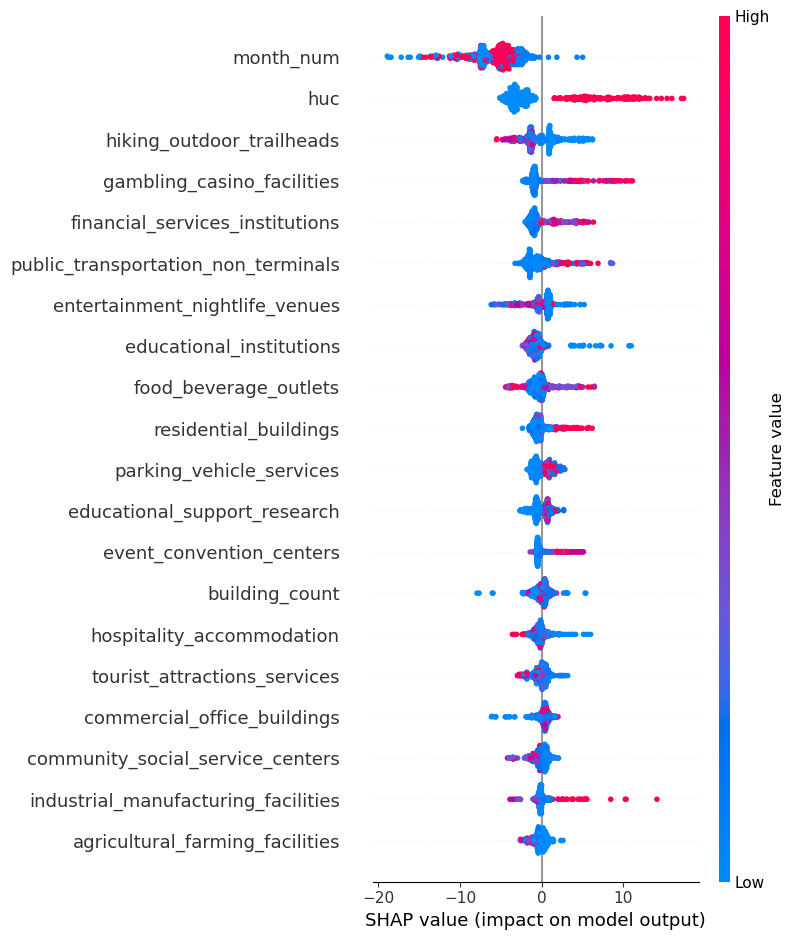

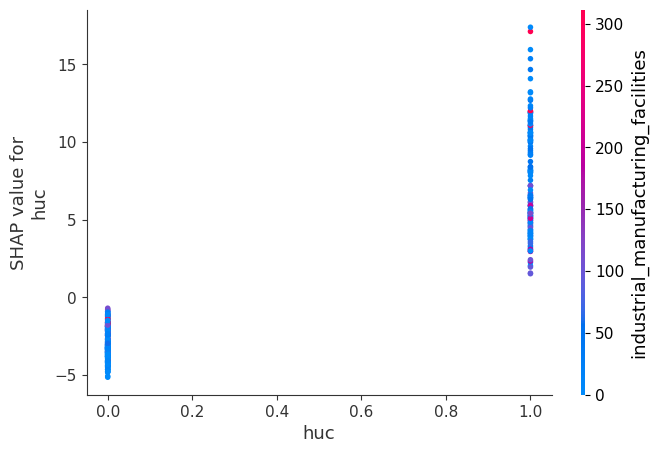

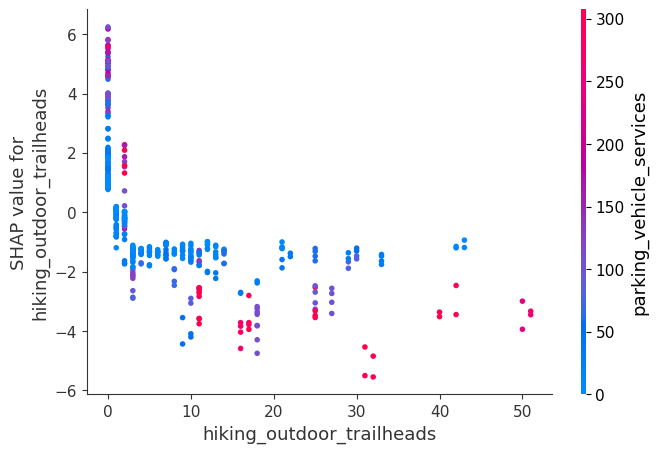

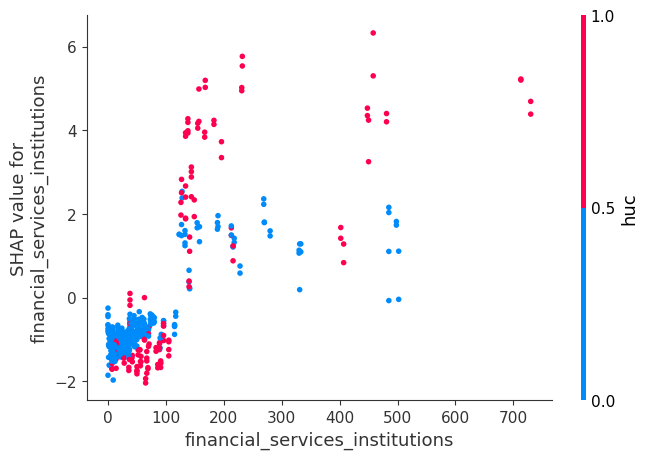

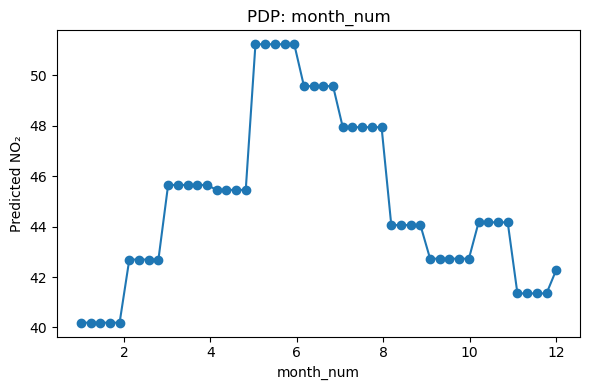

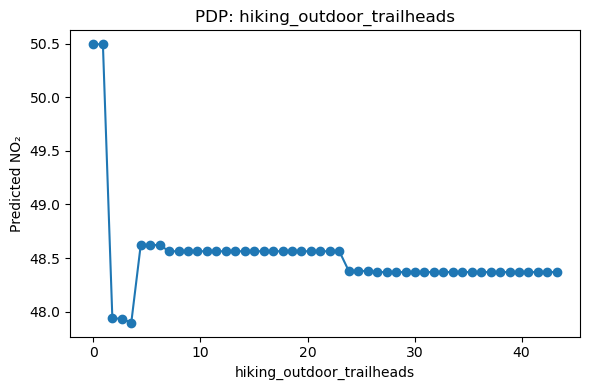

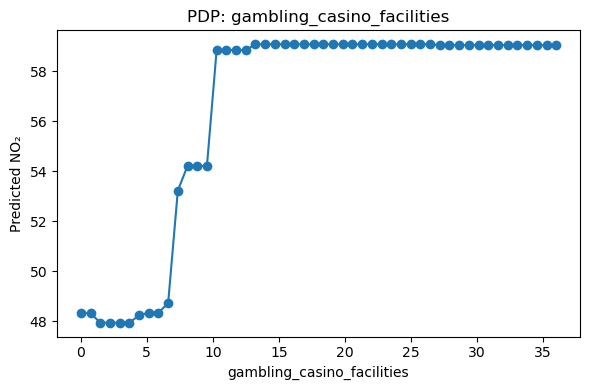

Pre-pandemic: Naive={'MAE': 4.014480015723101, 'RMSE': 8.108878106776919, 'SMAPE': 0.0673036393718248}, XGBoost={'MAE': 6.250249054387715, 'RMSE': 10.196007300026443, 'SMAPE': 0.11507494862036535}


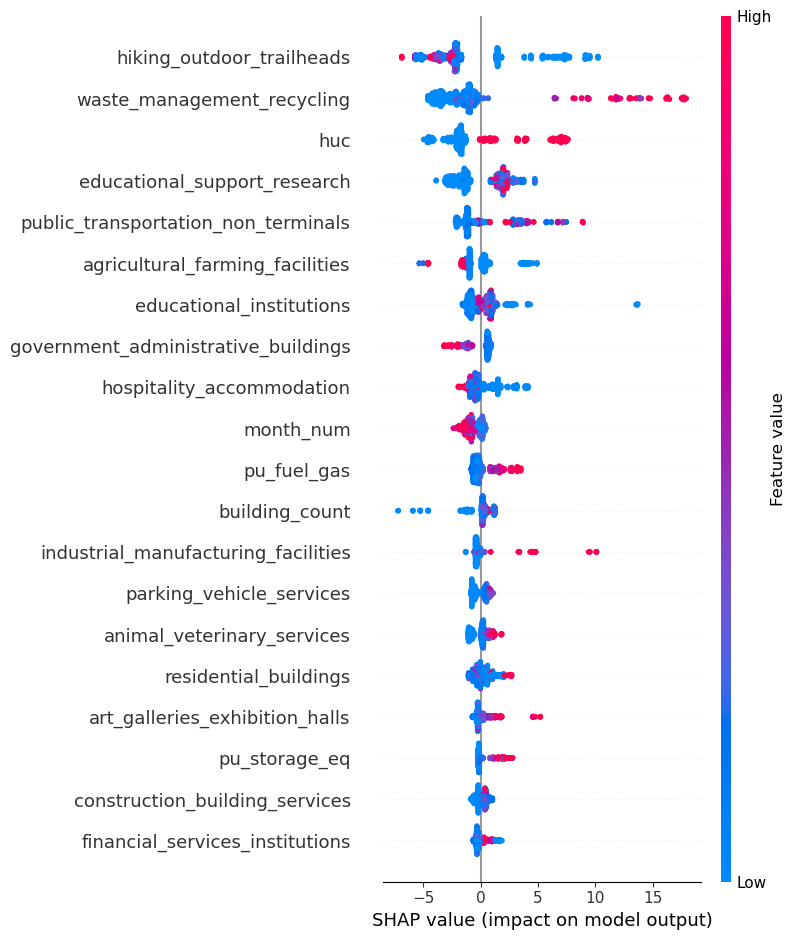

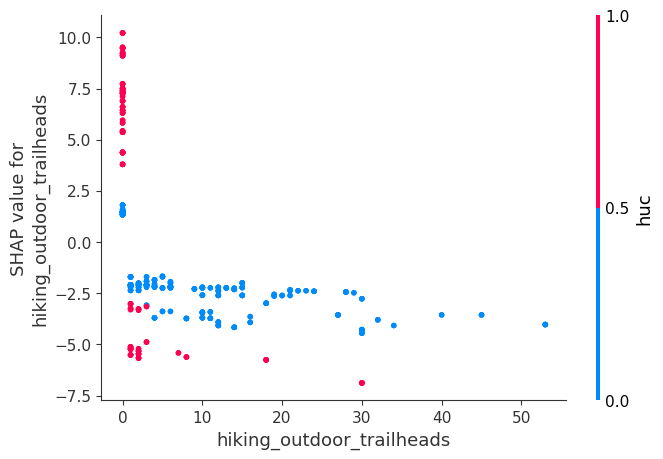

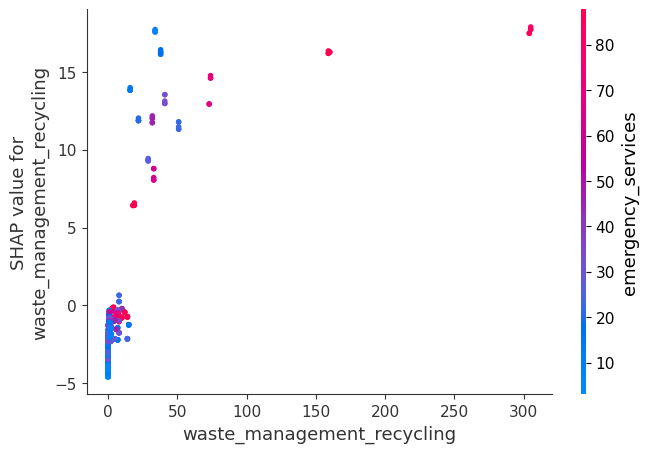

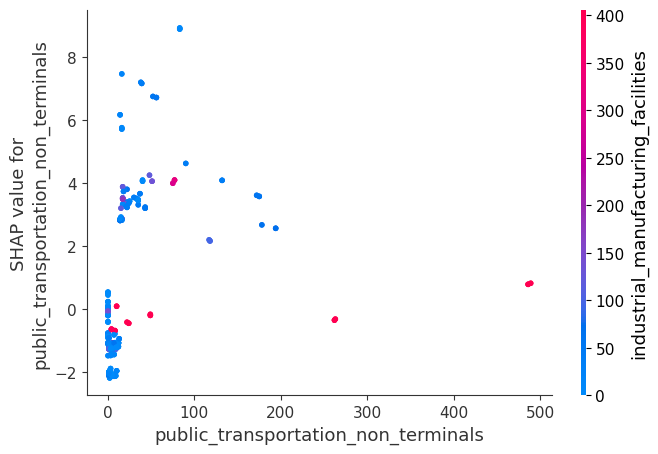

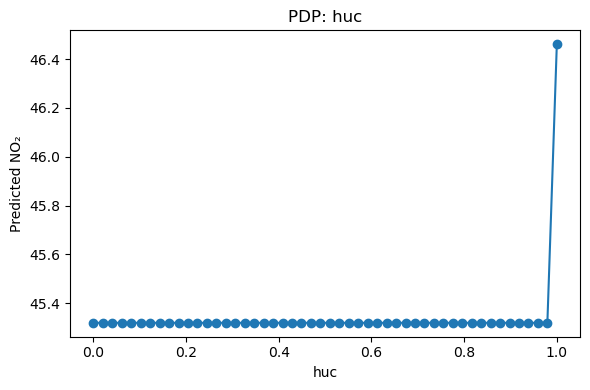

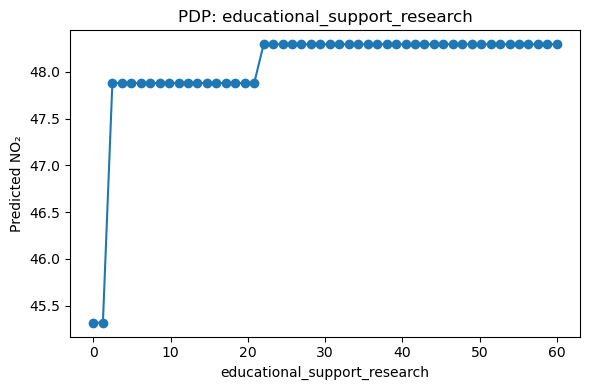

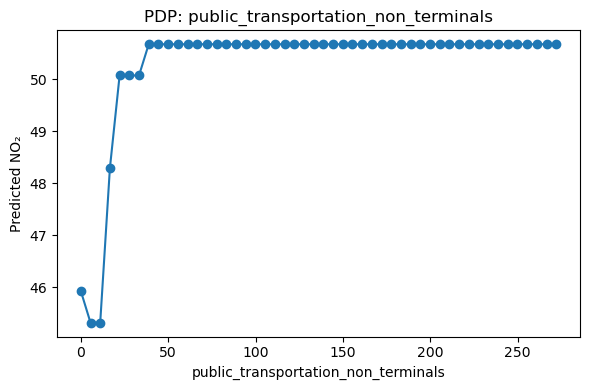

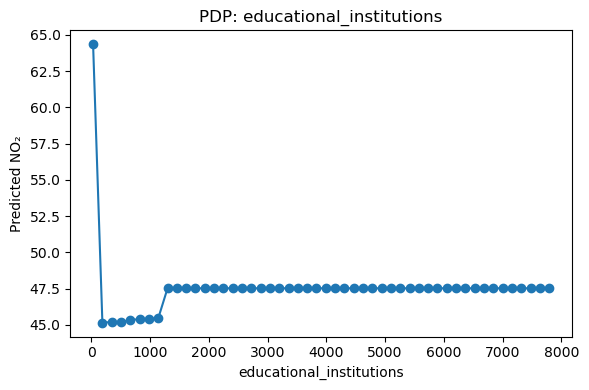

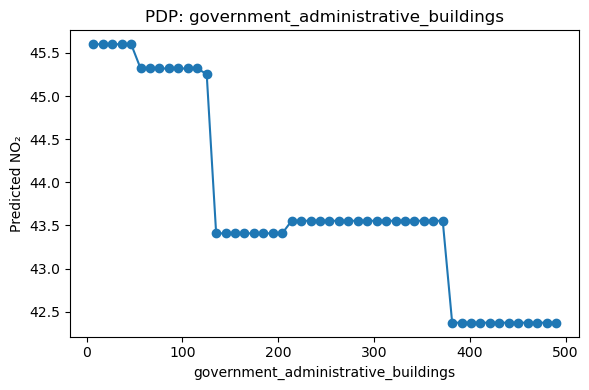

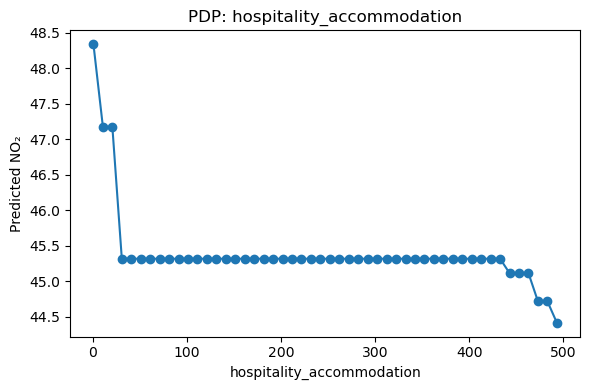

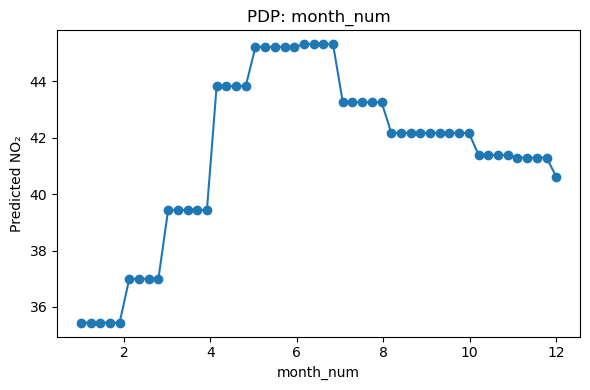

During-pandemic: Naive={'MAE': 2.9805142330437446, 'RMSE': 4.943397329921764, 'SMAPE': 0.04857276019184429}, XGBoost={'MAE': 3.360821952991395, 'RMSE': 4.778042169459791, 'SMAPE': 0.061140322179013926}


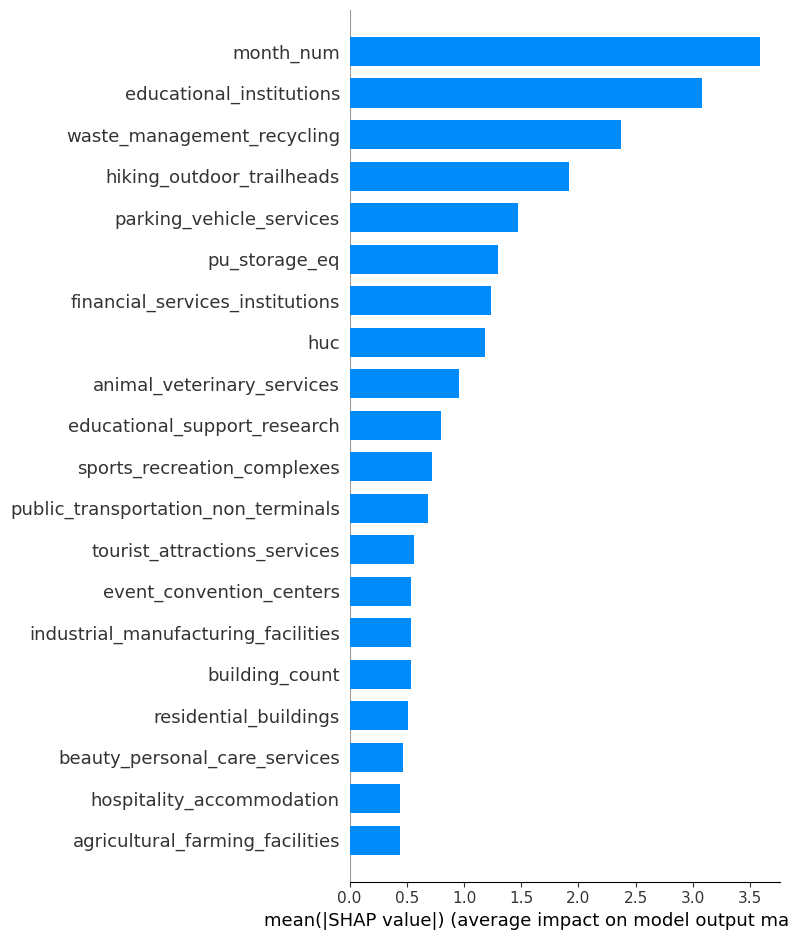

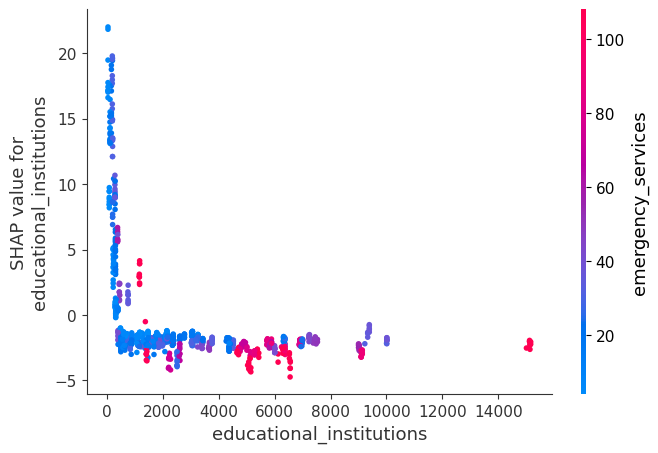

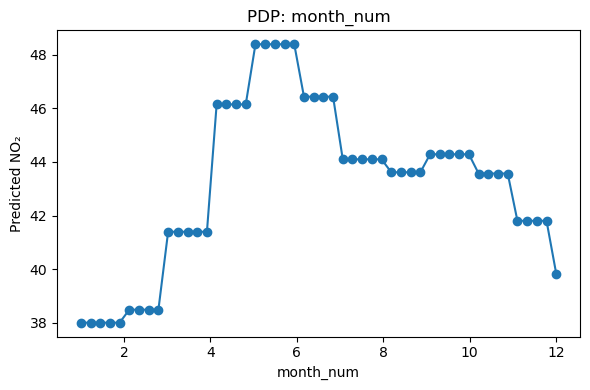

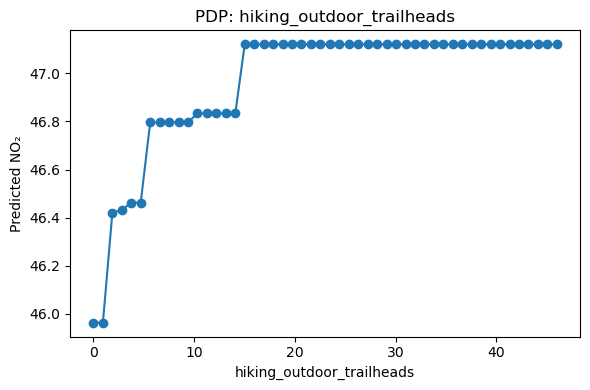

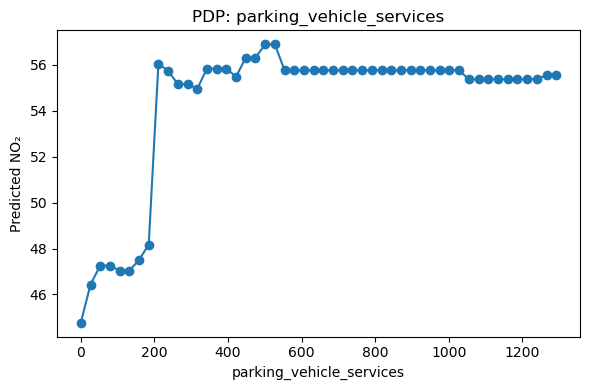

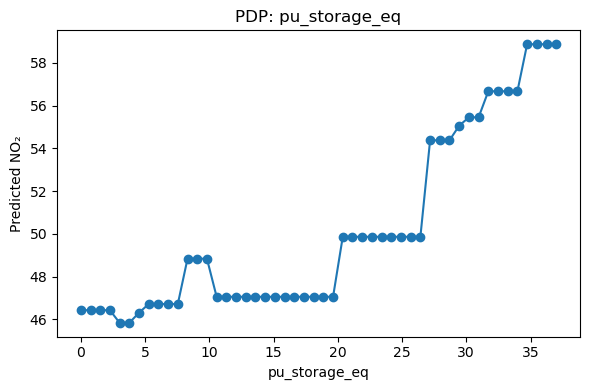

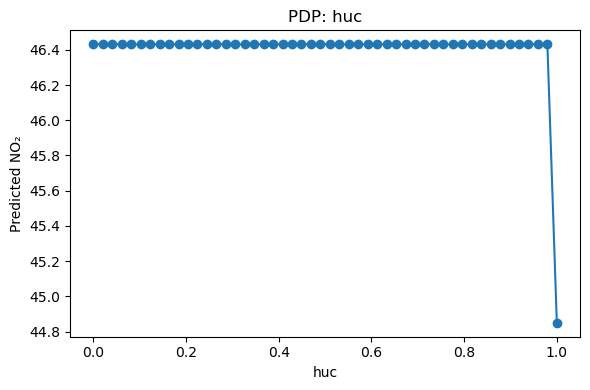

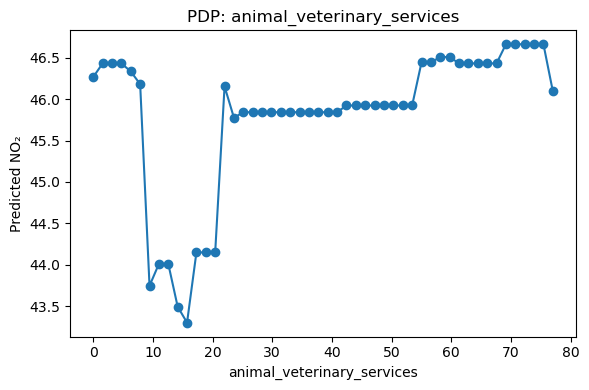

Post-pandemic: Naive={'MAE': 4.3628693560827845, 'RMSE': 7.573211188155469, 'SMAPE': 0.07346189090736557}, XGBoost={'MAE': 4.4000523885646325, 'RMSE': 6.572706636513275, 'SMAPE': 0.08132266970882858}


In [32]:
periods = {
    'Pre-pandemic': df_full[df_full['month'] < '2020-03-01'],
    'During-pandemic': df_full[(df_full['month'] >= '2020-03-01') & (df_full['month'] < '2022-01-01')],
    'Post-pandemic': df_full[df_full['month'] >= '2022-01-01']
}
res = {}
for name, subset in periods.items():
    train_df, val_df = time_based_split(subset)
    naive_metrics = evaluate_naive(val_df)
    xgb_model, xgb_metrics, top10_feats = train_and_evaluate_xgb(train_df, val_df)
    res[name] = {
        'naive': naive_metrics,
        'xgb': xgb_metrics,
        'top10': top10_feats,
        'model': xgb_model,
        'X_val': val_df.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    }
    print(f"{name}: Naive={naive_metrics}, XGBoost={xgb_metrics}")

#### 5 MODEL COMPARISON TABLE

In [33]:
summary = pd.DataFrame([
    {'Period': period, 'Model': model_type, **metrics}
    for period, vals in res.items()
    for model_type, metrics in [('Naive', vals['naive']), ('XGBoost', vals['xgb'])]
])
summary['SMAPE'] = (summary['SMAPE'] * 100).round(2).astype(str) + '%'
summary[['MAE', 'RMSE']] = summary[['MAE', 'RMSE']].round(2)
print('\nModel Comparison Table:')
print(summary.to_string(index=False))

# ------------------------------------------------------------
# 6) TOP 10 FEATURE CONTRIBUTIONS TABLE
# ------------------------------------------------------------
top10_rows = []
for period, vals in res.items():
    for rank, (feat, imp) in enumerate(vals['top10'], start=1):
        top10_rows.append({
            'Period': period,
            'Rank': rank,
            'Feature': feat,
            'MeanAbsSHAP': round(imp, 4)
        })
features_df = pd.DataFrame(top10_rows)
print('\nTop 10 Feature Contributions per Period:')
print(features_df.to_string(index=False))


Model Comparison Table:
         Period   Model  MAE  RMSE  SMAPE
   Pre-pandemic   Naive 4.01  8.11  6.73%
   Pre-pandemic XGBoost 6.25 10.20 11.51%
During-pandemic   Naive 2.98  4.94  4.86%
During-pandemic XGBoost 3.36  4.78  6.11%
  Post-pandemic   Naive 4.36  7.57  7.35%
  Post-pandemic XGBoost 4.40  6.57  8.13%

Top 10 Feature Contributions per Period:
         Period  Rank                             Feature  MeanAbsSHAP
   Pre-pandemic     1                           month_num       5.7562
   Pre-pandemic     2                                 huc       4.2944
   Pre-pandemic     3           hiking_outdoor_trailheads       1.8245
   Pre-pandemic     4          gambling_casino_facilities       1.7209
   Pre-pandemic     5     financial_services_institutions       1.3558
   Pre-pandemic     6 public_transportation_non_terminals       1.3362
   Pre-pandemic     7      entertainment_nightlife_venues       1.2429
   Pre-pandemic     8            educational_institutions       1.0981


#### 6 PDP FOR METROPOLITAN CITIES POST PANDEMIC

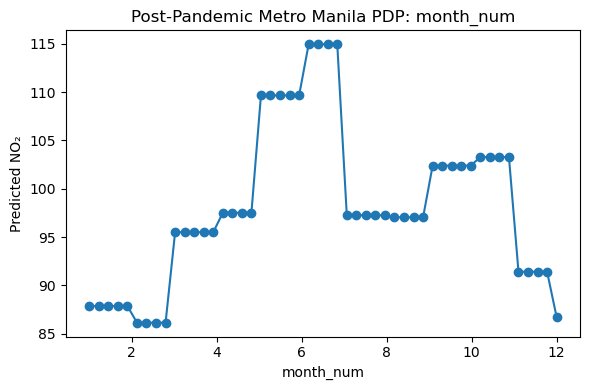

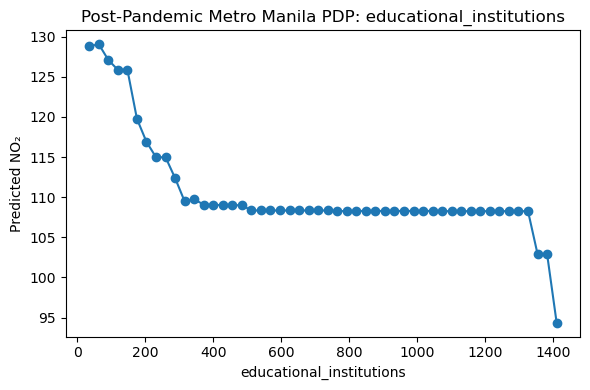

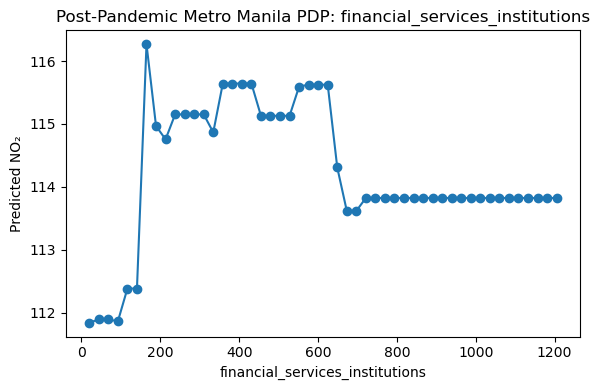

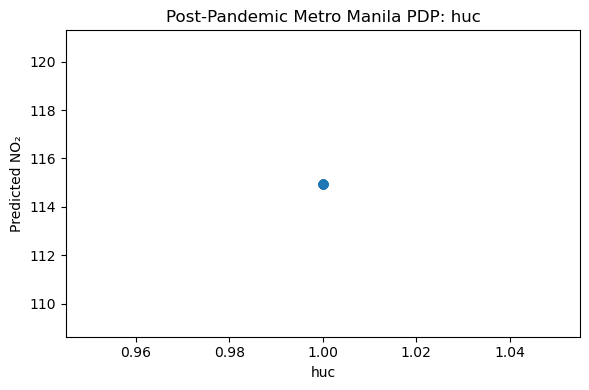

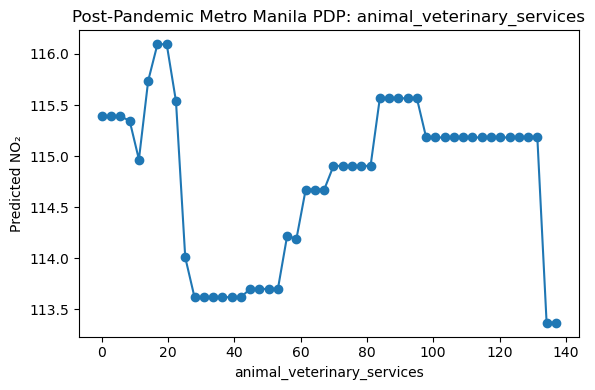

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Metro Manila city list (adjust if needed)
metro_cities = [
    'city of manila', 'quezon city', 'city of caloocan', 'city of las piñas',
    'city of makati', 'city of malabon', 'city of mandaluyong', 'city of marikina',
    'city of muntinlupa', 'city of navotas', 'city of parañaque', 'pasay city',
    'city of pasig', 'pateros', 'city of san juan', 'city of taguig'
]

# 1) Pull out your post-pandemic model + features
post_model    = res['Post-pandemic']['model']
post_top10    = res['Post-pandemic']['top10']   # list of (feat, importance)
post_period   = periods['Post-pandemic']        # DataFrame of post-pandemic rows

# 2) Build the Metro Manila numeric matrix
df_metro = post_period[post_period['region'].isin(metro_cities)]
X_metro  = df_metro.drop(columns=EXCLUDE + ['month'], errors='ignore') \
                   .select_dtypes(include='number')

# 3) Compute the Metro median profile
metro_median = X_metro.median()

# 4) Loop over the top-10 features from your post-pandemic run
for feat, _ in post_top10:
    # 4a) Grid between 1st–99th percentile **within** Metro Manila
    grid = np.linspace(
        X_metro[feat].quantile(0.01),
        X_metro[feat].quantile(0.99),
        50
    )
    # 4b) Make a DataFrame at the Metro median, varying only this feature
    df_grid = pd.DataFrame(
        np.repeat(metro_median.values[None, :], len(grid), axis=0),
        columns=X_metro.columns
    )
    df_grid[feat] = grid

    # 4c) Predict and plot
    y_pred = post_model.predict(df_grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, y_pred, marker='o')
    plt.title(f'Post-Pandemic Metro Manila PDP: {feat}')
    plt.xlabel(feat)
    plt.ylabel('Predicted NO₂')
    plt.tight_layout()
    plt.show()


#### PDP REGION POST-PANDEMIC

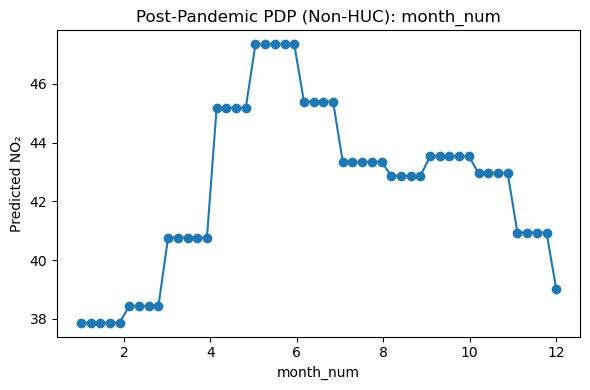

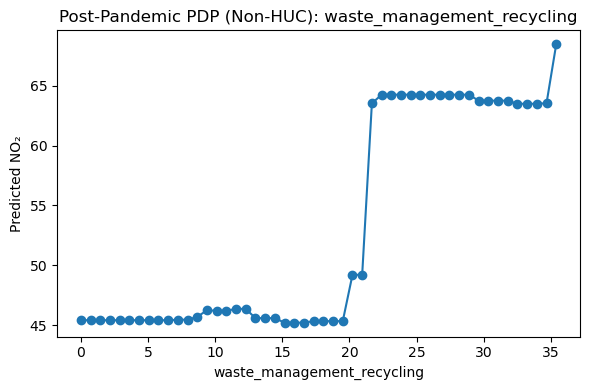

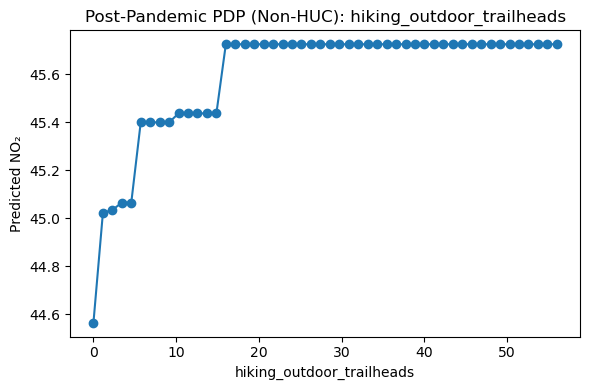

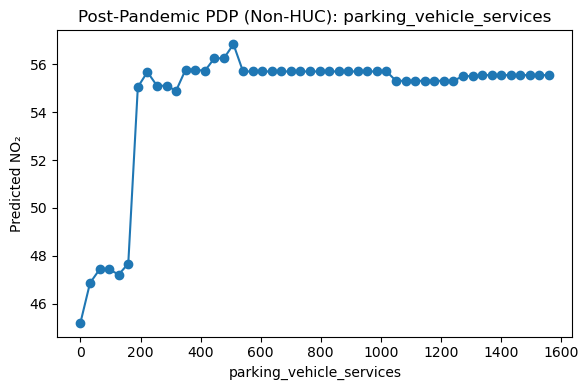

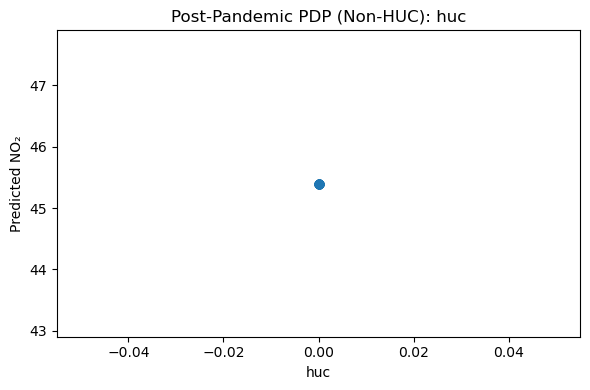

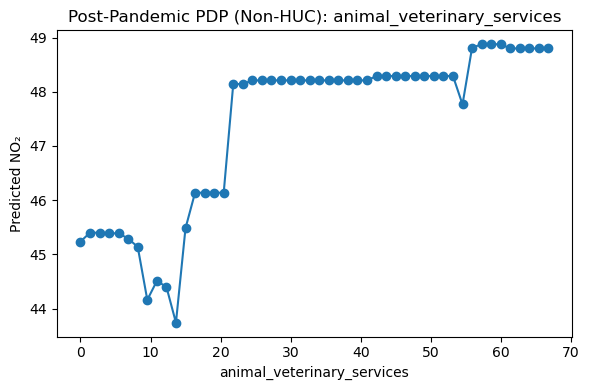

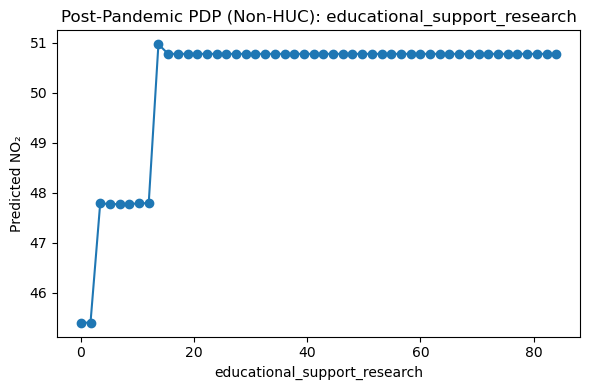

In [35]:
# 1) Pull out your post-pandemic model + features
post_model    = res['Post-pandemic']['model']   # 
post_top10    = res['Post-pandemic']['top10']   # list of (feat, importance)
post_period   = periods['Post-pandemic']        # DataFrame of post-pandemic rows

# 2) Filter to NON-HUC regions only
df_nonhuc = post_period[~post_period['region'].str.lower().isin(huc_list)]
X_nonhuc  = df_nonhuc.drop(columns=EXCLUDE + ['month'], errors='ignore') \
                     .select_dtypes(include='number')

# 3) Compute the median profile for non-HUC regions
nonhuc_median = X_nonhuc.median()

# 4) Loop over the top-10 features
for feat, _ in post_top10:
    # 4a) Grid between 1st–99th percentile in non-HUC data
    grid = np.linspace(
        X_nonhuc[feat].quantile(0.01),
        X_nonhuc[feat].quantile(0.99),
        50
    )

    # 4b) Create grid DataFrame at median, varying only one feature
    df_grid = pd.DataFrame(
        np.repeat(nonhuc_median.values[None, :], len(grid), axis=0),
        columns=X_nonhuc.columns
    )
    df_grid[feat] = grid

    # 4c) Predict and plot
    y_pred = post_model.predict(df_grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, y_pred, marker='o')
    plt.title(f'Post-Pandemic PDP (Non-HUC): {feat}')
    plt.xlabel(feat)
    plt.ylabel('Predicted NO₂')
    plt.tight_layout()
    plt.show()

## VII. Results and Discussion

### Model Performance Comparison  

| Period            | Model   | MAE | RMSE | SMAPE |
|-------------------|---------|-----|------|-------|
| **Pre-pandemic**  | Naive   | 4.01 | 8.11 | 6.73 % |
|                   | XGBoost | 6.25 | 10.20 | 11.51 % |
| **During-pandemic** | Naive   | 2.98 | 4.94 | 4.86 % |
|                   | XGBoost | 3.36 | 4.78 | 6.11 % |
| **Post-pandemic** | Naive   | 4.36 | 7.57 | 7.35 % |
|                   | XGBoost | 4.40 | 6.57 | 8.13 % |


* Persistence leads the pack.  
  Using last month’s NO₂ as the prediction (the Naïve baseline) delivers the lowest MAE and SMAPE in every phase, reflecting the strong month-to-month inertia typical of tropospheric NO₂.

* XGBoost still adds value.  
  Although its point forecasts are slightly less accurate, XGBoost produces the feature importance scores (via SHAP) that tell us why NO₂ changes with different amenity interactions.

# Top 10 Feature Contributions by Pandemic Period

## Pre-pandemic
| Rank | Feature | Mean Abs SHAP |
|------|---------|---------------|
| 1 | huc | 7.3190 |
| 2 | month_num | 5.7079 |
| 3 | hospitality_accommodation | 1.5198 |
| 4 | public_transportation_non_terminals | 1.2597 |
| 5 | entertainment_nightlife_venues | 1.1686 |
| 6 | agricultural_farming_facilities | 1.1055 |
| 7 | pu_storage_eq | 1.0929 |
| 8 | financial_services_institutions | 1.0321 |
| 9 | residential_buildings | 0.9826 |
| 10 | emergency_services | 0.8722 |

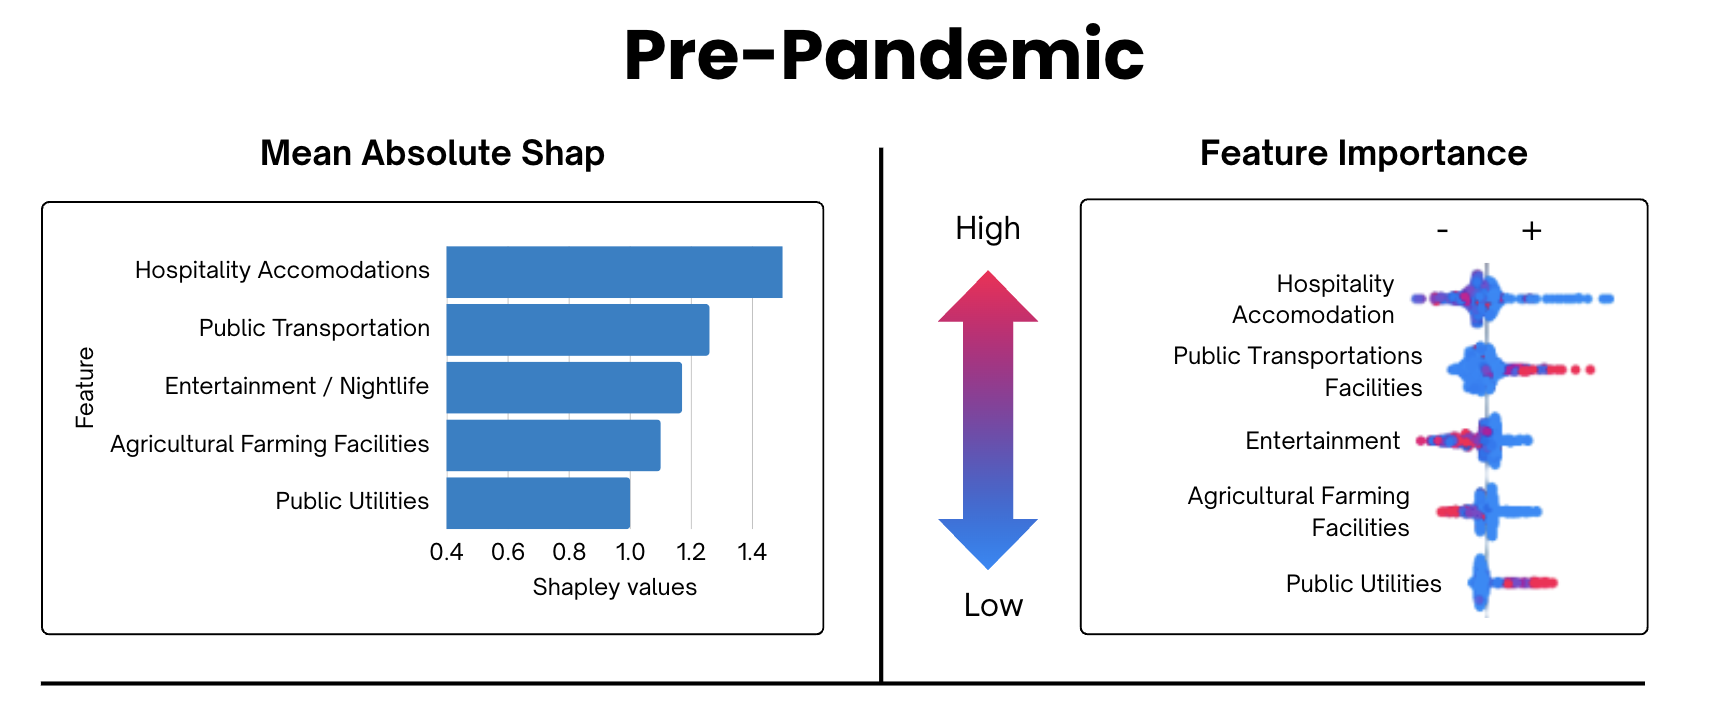

The SHAP summary reveals two behaviour clusters among the top amenities that shaped NO₂ levels before COVID-19:

| Amenity Group | SHAP Direction | What It Means |
|---------------|---------------|---------------|
| Hospitality accommodation<br>Public-transport facilities | Positive contribution (blue points shift to the right) | Areas with more hotels, hostels, terminals, and depots recorded *higher* monthly NO₂.  Tourist inflows, HVAC electricity demand, idling buses/jeepneys, and feeder traffic all intensify combustion emissions. |
| Entertainment venues<br>Agricultural farming facilities<br>Public-utility sites | Negative / neutral contribution (blue points lean to the left or cluster near zero) | These amenities tend to coincide with lower-density zones or operate intermittently. <br>• Entertainment clusters (e.g., cinemas, event halls) are often in peri-urban areas with dispersed parking and evening-only peaks, so their monthly average effect is slightly *downward* or neutral. <br>• Agricultural facilities mark rural settings where traffic is sparse and vegetation is abundant, naturally diluting NO₂. <br>• Utility compounds (water, power substations) are few, spatially isolated, and show negligible net impact at the regional scale. |

Before the pandemic, mobility-intensive amenities—hotels and transport hubs—were the primary NO₂ amplifiers**, while entertainment districts, farm-oriented amenities, and scattered utility sites exerted either a neutral or mildly mitigating influence on monthly concentrations.


## During-pandemic
| Rank | Feature | Mean Abs SHAP |
|------|---------|---------------|
| 1 | waste_management_recycling | 3.4474 |
| 2 | huc | 3.2335 |
| 3 | hiking_outdoor_trailheads | 2.6268 |
| 4 | public_transportation_non_terminals | 1.8737 |
| 5 | educational_support_research | 1.5454 |
| 6 | agricultural_farming_facilities | 1.4789 |
| 7 | educational_institutions | 0.8698 |
| 8 | month_num | 0.7927 |
| 9 | government_administrative_buildings | 0.7742 |
| 10 | hospitality_accommodation | 0.7550 |



| Amenity Group | SHAP Direction | What It Means |
|---------------|----------------|---------------|
| Waste management facilities | **Positive (strongest)** | Became the top contributor to NO₂ levels, reflecting increased domestic waste and operational demands from landfills and transfer stations |
| Hiking and outdoor areas (green spaces) | **Negative** | Rose in importance — helping disperse NO₂ and associated with lower NO₂ concentrations as other pollution sources declined |
| Public transportation | **Positive (mixed)** | Remained a factor, though reduced due to mobility restrictions |
| Agricultural farming facilities | **Negative** | Associated with lower NO₂ concentrations in rural areas with natural buffers |

Pandemic restrictions fundamentally flipped the NO₂ hierarchy. Essential services (waste management) became the dominant emission sources, while traditional high-emission activities like urban traffic and school operations were severely curtailed. Hiking and outdoor areas (green spaces) rose in importance — helping disperse NO₂ and associated with lower NO₂ concentrations as other pollution sources declined.

## Post-pandemic
| Rank | Feature | Mean Abs SHAP |
|------|---------|---------------|
| 1 | waste_management_recycling | 4.0250 |
| 2 | month_num | 3.7451 |
| 3 | educational_institutions | 3.1346 |
| 4 | hiking_outdoor_trailheads | 1.4097 |
| 5 | agricultural_farming_facilities | 1.3194 |
| 6 | pu_storage_eq | 1.2996 |
| 7 | parking_vehicle_services | 1.2348 |
| 8 | financial_services_institutions | 1.1919 |
| 9 | huc | 1.0173 |
| 10 | government_administrative_buildings | 1.0095 

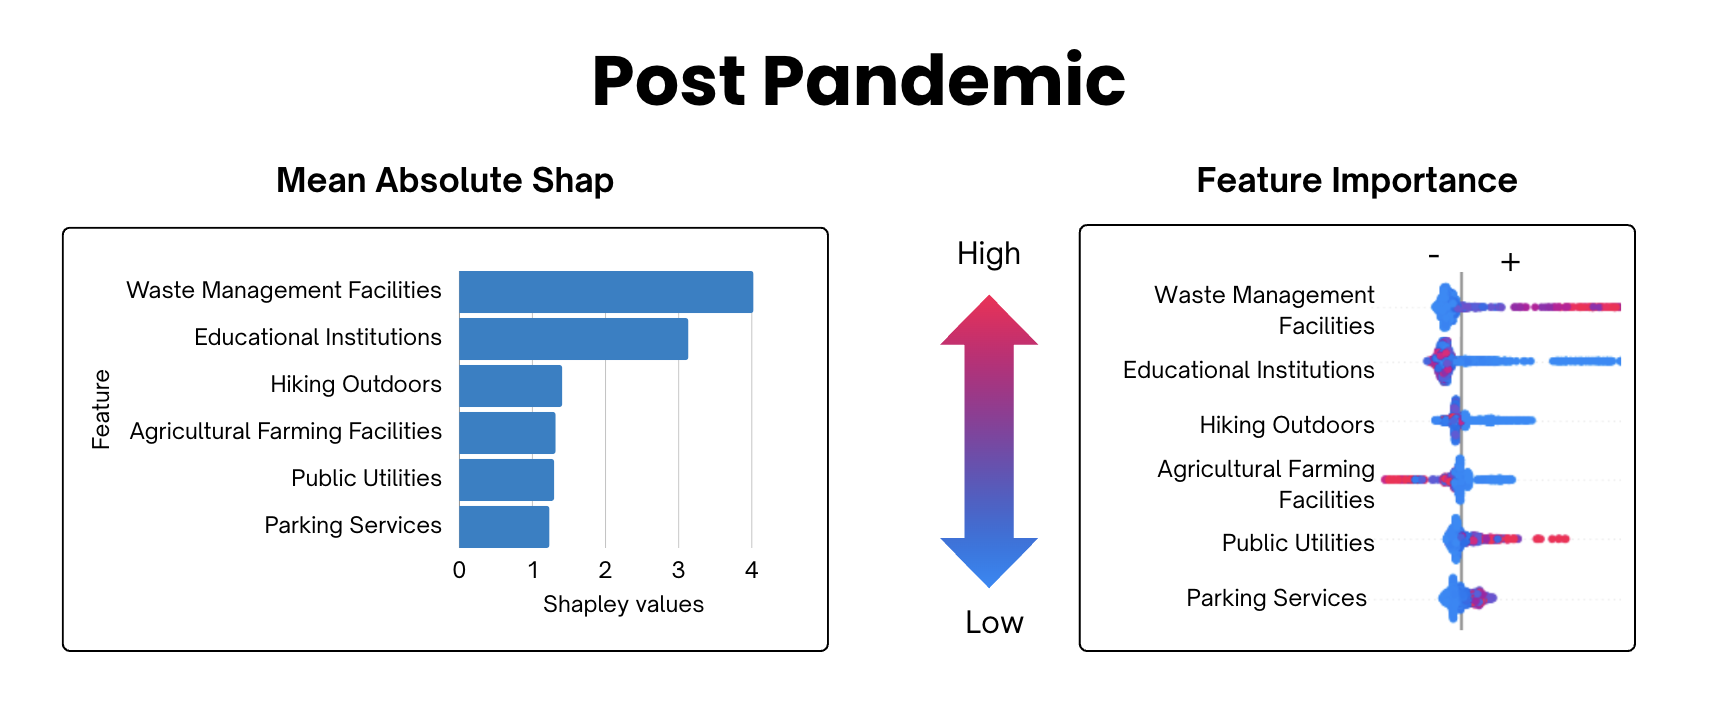

# Post-Pandemic Phase SHAP Analysis: Amenity Groups and NO₂ Contributions

| Amenity Group | SHAP Direction | What It Means |
|---------------|----------------|---------------|
| Waste management facilities | **Positive (strongest)** | Remained the top contributor to NO₂ levels, maintaining their dominance from the pandemic period |
| Educational institutions | **Positive (strong)** | Regained prominence with the return of in-person schooling and mobility, bringing back campus activities and commuting patterns |
| Public utilities | **Positive (moderate)** | Reflects the broader reactivation of urban mobility and services as economic activities resumed |
| Parking services | **Positive (moderate)** | Reflects the broader reactivation of urban mobility and services as people returned to pre-pandemic transportation patterns |
| Hiking/outdoor amenities | **Negative** | Continued to help mitigate NO₂ levels as green spaces maintain their air quality benefits |
| Agricultural facilities | **Negative** | Continued to help mitigate NO₂ levels through rural settings with natural buffers and lower baseline emissions |

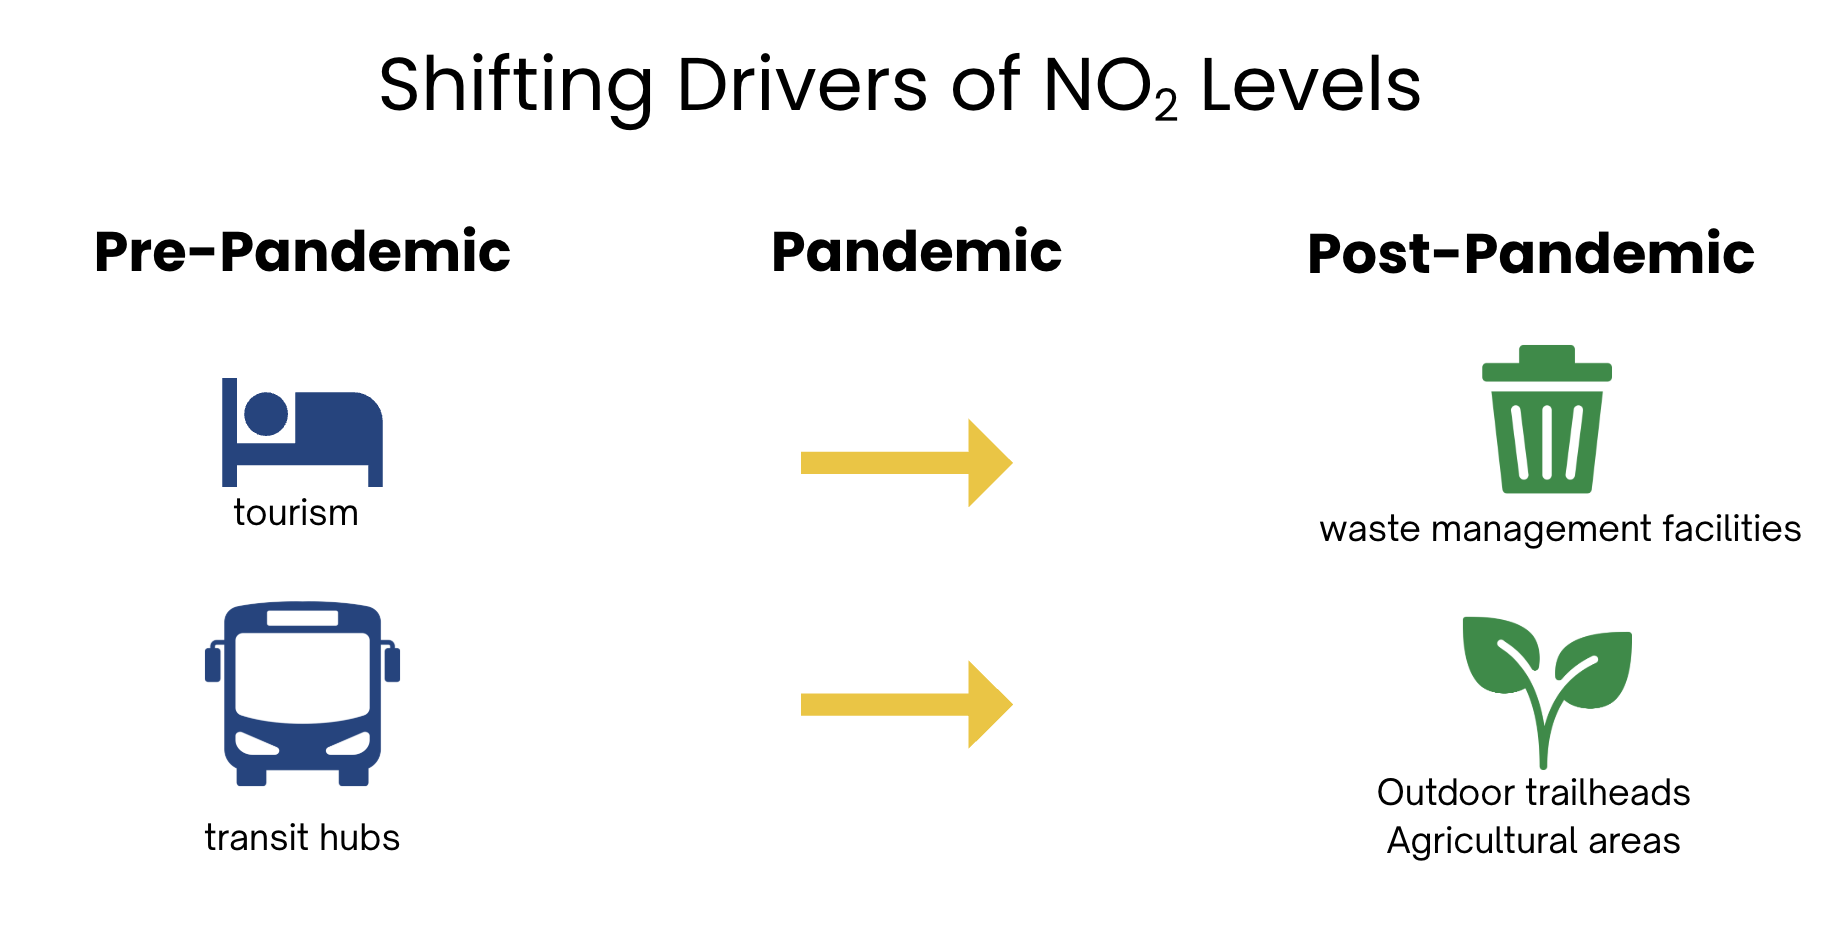

Post-pandemic recovery shows a partial return to pre-pandemic patterns with persistent changes. Waste management facilities maintained their pandemic-era dominance as the top NO₂ contributor, while educational institutions and urban services rebounded strongly as schools reopened and mobility resumed. Green spaces (hiking areas and agricultural facilities) continued providing air quality benefits, suggesting a "new normal" where essential services remain elevated contributors while traditional urban activities gradually recover.

## IX. Recommendation

At the policy level, integrating real-time NO₂ dashboards into the Climate-Change Expenditure Tagging (CCET) workflow—an instrument developed as an off-shoot of the Philippines’ National Climate Change Action Plan (NCCAP)¹—would allow project appraisers to factor air-quality impacts directly into funding decisions. Crucially, the dashboard could potentially be deployed to cities as well as municipalities nationwide and packaged as a hazard-mapping and emissions-forecasting tool that local governments can deploy during infrastructure planning and procurement. Operating at this granular level adds two practical benefits: (1) it lets reviewers verify whether the emissions claims in project proposals match model-based forecasts, and (2) it supports lifecycle assessments by comparing the predicted environmental impacts of competing bids. As richer data streams become available, the same framework can be expanded to cover additional pollutants—particularly PM₂.₅ and SO₂—so that decision-makers gain a comprehensive view of atmospheric risks.

## X. Conclusion

Our analysis demonstrates that amenity-aware machine-learning models, when paired with satellite observations, can generate robust, period-specific forecasts of NO₂ hotspots—evidence that squarely matches the data needs of the Climate-Change Expenditure Tagging (CCET) process. The timing is fortuitous: Republic Act No. 12009, the 2024 “New Government Procurement Act,” now obliges large infrastructure bidders to disclose baseline pollution impacts. ¹ A government-facing dashboard may be built on our model to help regulators meet that mandate. Looking ahead, the same modelling framework could also be expanded to additional pollutants such as PM₂.₅ and SO₂. In short, dynamic amenity data, transparent machine learning (ML) forecasts, and the country’s evolving procurement rules together offer a credible roadmap to make green initiatives not merely compliant but genuinely evidence-based and climate-resilient.

## XI. References

- European Space Agency. (2025). *Sentinel-5P OFFL L3 NO₂ tropospheric column number density* [Satellite data set]. Copernicus Open Access Hub. Retrieved June 10, 2025, from https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2

- OpenStreetMap contributors. (2025). *Planet dump* [Geospatial data set]. Retrieved June 10, 2025, from https://planet.openstreetmap.org/

- Environmental Management Bureau. (2024). *Ambient air quality hourly data, Metro Manila network*: 2023–2024 download. Department of Environment and Natural Resources.

- World Health Organization. (2021). *WHO global air quality guidelines: Particulate matter (PM₂.₅ and PM₁₀), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide. Geneva*: WHO.

- Climate Change Commission. (2011). *National Climate Change Action Plan 2011–2028. Manila*: Government of the Philippines.

- Republic of the Philippines. *Republic Act No. 12009: New Government Procurement Act*. Official Gazette, 17 March 2024